In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

from matplotlib import pyplot as plt
import statsmodels.api as sm
from sklearn import linear_model
from sklearn.linear_model import Lasso, ElasticNet, LogisticRegression
from sklearn import preprocessing
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder, StandardScaler, StandardScaler
from sklearn.inspection import permutation_importance

from matplotlib.ticker import MultipleLocator
from sklearn.utils import class_weight
from sklearn import svm
import scipy.stats as stats 

from sklearn import metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.linear_model import RidgeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold, StratifiedKFold
from decimal import Decimal
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor
from collections import defaultdict
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, KFold
from typing import Tuple
from math import sqrt
from scipy.stats import ranksums, pearsonr, spearmanr
from statsmodels.stats.multitest import multipletests

from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
import xgboost as xgb
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import metrics
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.ensemble import HistGradientBoostingClassifier

from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.metrics import roc_curve, RocCurveDisplay, auc
from sklearn.neural_network import MLPClassifier
from wordcloud import WordCloud, ImageColorGenerator
import pingouin as pg

plt.rcParams['pdf.fonttype'] = 42

In [2]:
print('\n'.join(f'{m.__name__}=={m.__version__}' for m in globals().values() if getattr(m, '__version__', None)))

pandas==2.0.3
numpy==1.25.2
seaborn==0.12.2
statsmodels.api==0.13.5
xgboost==1.7.3
pingouin==0.5.4


In [3]:
import sklearn
sklearn.__version__

'1.3.0'

In [4]:
DF = pd.read_csv('result_datasets/Moby_genes_features_GSEA.csv', index_col=0)
# Delete duplicated column 
DF = DF.loc[:,~DF.columns.duplicated()].copy()
DF = DF[DF['cai'].notna()]

In [5]:
DF.shape

(4456, 139)

In [6]:
tmp = DF[['logFC', 'FDR']]
tmp['logFDR'] = -np.log2(tmp['FDR'])

C:\Users\user\AppData\Local\Temp\ipykernel_13060\253371650.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp['logFDR'] = -np.log2(tmp['FDR'])


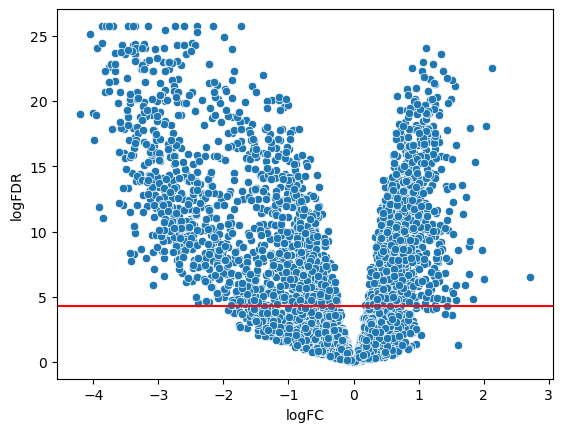

In [7]:
sns.scatterplot(data=tmp, x='logFC', y='logFDR')
plt.axhline(y=-np.log2(0.05), color='red') 

In [8]:
tmp.sort_values('logFC')

,logFC,FDR,logFDR
Gene,,,
YAK1,-4.210378,1.880990e-06,19.020077
MET14,-4.053835,2.726724e-08,25.128256
STV1,-4.000224,1.770428e-06,19.107470
OM45,-3.991291,7.398765e-06,17.044284
MSY1,-3.951757,2.011719e-06,18.923140
...,...,...,...
YML007C-A,1.968386,2.631169e-03,8.570080
YKR078W,1.997667,1.249037e-02,6.323040
GLC7,2.030262,3.627248e-06,18.072693


In [9]:
# delete redundant features
df_short = DF.copy()
df_short = df_short.drop(['5UTR_PARS_RNAstructure', 'CDS_PARS_RNAstructure', 'MS mean', 'log2(MS)',
'3UTR_PARS_RNAstructure', 'Ribo_profilling_ribo_num', 'Ribo_profilling_trans_time', 'protein_synthesis_rate', 
'real_protein_synthesis_rate','Ribo_profilling_delay_time', 'Control Median', 'Sum Odds Ratio',
'intron length','median transcript length', 'control Localization', 'NAME', 'ORF.length', 'molecularWeight'], axis=1)
df_short = df_short.replace( 'Potential_AUG_annotation_error', np.nan)

In [10]:
# remove row with more than 6 nan values
df_short = df_short.dropna(thresh=df_short.shape[1]-6)

In [11]:
# Since positive and negative interactio are correlated, sum them up
df_short['number of genetic interaction'] = df_short['number of positive genetic interaction'] + df_short['number of negative genetic interaction']
df_short['IDR ratio mean'] =(df_short['IDR ratio'] + df_short['alpha IDRratio'])/2

In [12]:
# Fill na with median of each column
DF_imputed = df_short.copy()
feat = ['median_IUPRED', 'Ribo_profilling_init_rate', 'Ribo_profilling_trans_rate', 'cai', 'IDR ratio mean',
       "5'-UTR_length", "3'-UTR_length", 'protein half-life (hr)', 'mRNA half-life (min)', 'alpha IDRratio', 'A3D mean score', 'A3D ratio', 
        'A3D mean +score', 'DisoRDPbind_PRO', 'DisoRDPbind_DNA', 'DisoRDPbind_RNA', 'DRNApred_DNA', 'DRNApred_RNA', 'SCRIBER_PRO', 'flDPnn_disorder']
DF_imputed[feat] = DF_imputed[feat].fillna(value=DF_imputed[feat].median())
,
# Imputation of missing values 
DF_imputed['RNAseq Eupl'] = DF_imputed['RNAseq Eupl'].fillna(0)
DF_imputed['rna FC - other'] = DF_imputed['rna FC - other'].fillna(0)
DF_imputed['rna logFC'] = DF_imputed['rna logFC'].fillna(0)

DF_imputed['Ubiquitilation number'] = DF_imputed['Ubiquitilation number'].fillna(0)
DF_imputed['Phosphorylation number'] = DF_imputed['Phosphorylation number'].fillna(0)

DF_imputed['number of physical interaction'] = DF_imputed['number of physical interaction'].fillna(0)
DF_imputed['number of positive genetic interaction'] = DF_imputed['number of positive genetic interaction'].fillna(0)
DF_imputed['number of negative genetic interaction'] = DF_imputed['number of negative genetic interaction'].fillna(0)

DF_imputed[['number of physical interaction',
       'number of positive genetic interaction',
       'number of negative genetic interaction', 'number of ppi, all',
       'number of ppi, score >= 0.25', 'number of ppi, score > 0.5',
       'number of ppi, score > 0.8', 'number of ppi, score >= 0.95']] = DF_imputed[['number of physical interaction',
       'number of positive genetic interaction',
       'number of negative genetic interaction', 'number of ppi, all',
       'number of ppi, score >= 0.25', 'number of ppi, score > 0.5',
       'number of ppi, score > 0.8', 'number of ppi, score >= 0.95']].fillna(0)
DF_imputed["5'-UTR_length"] = DF_imputed["5'-UTR_length"].astype('float')

In [13]:
# Check no missing values 
DF_imputed.isna().sum().sort_values(ascending=False).head(5)

Systematic name             0
PSIPRED_helix               0
has transmembrane domain    0
has disordered region       0
A3D mean +score             0
dtype: int64

In [14]:
# Normalize most features to 'gene length'
to_norm = ['Phosphorylation number', 'Ubiquitilation number', 'variants_impact_MODERATE',
       'variants_effect_missense_variant', 'variants_impact_LOW',
       'variants_effect_synonymous_variant']

for x in to_norm:
    df_short[x + ' norm_geneLen'] = df_short[x]/df_short['geneLen']*np.mean(df_short['geneLen'])

In [15]:
# Save that version of the DF for publication
df_short.to_csv('result_datasets/Moby1_genes_features_gsea_FINAL.csv')

In [16]:
f_name = df_short.isna().sum().to_frame()
f_name = f_name.rename(columns={0:'Number of missing values'})
f_name['% missing values'] = f_name['Number of missing values'] / df_short.shape[0]*100

In [17]:
f_name.to_csv('result_datasets/features_short_name.csv')

In [18]:
tmp = DF[['geneLen', 'rna logFC']]
tmp['log gene length'] = np.log2(tmp['geneLen'])
tmp.dropna(inplace= True)

C:\Users\user\AppData\Local\Temp\ipykernel_13060\962586983.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp['log gene length'] = np.log2(tmp['geneLen'])
C:\Users\user\AppData\Local\Temp\ipykernel_13060\962586983.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp.dropna(inplace= True)


In [19]:
# Number of deleterious gene once filtering genes with too many missing values
DF_imputed['Numeric Label'].sum()

1176

# Normalize numerical features to gene length (if make sense)

In [20]:
# to test, only numerical
l = ['GC_content','median_IUPRED', '%AA_A', '%AA_C', '%AA_D', '%AA_E', '%AA_F', '%AA_G',
       '%AA_H', '%AA_I', '%AA_K', '%AA_L', '%AA_M', '%AA_N', '%AA_P', '%AA_Q',
       '%AA_R', '%AA_S', '%AA_T', '%AA_V', '%AA_W', '%AA_Y','Acidic AA%', 'Basic AA%', 'Polar AA%',
       'Hydrophobic AA%', 'Charged AA%',  '%Helical',
       '%Proteinturn', '%Beta-sheet', 'number of physical interaction',
       'number of positive genetic interaction',
       'number of negative genetic interaction', 'number of ppi, all',
       'number of ppi, score >= 0.25', 'number of ppi, score > 0.5',
       'number of ppi, score > 0.8', 'number of ppi, score >= 0.95',
       'RNAseq Eupl', 'rna logFC', 'rna FC - other', 'Imputed log2(MS)', 'Ribo_profilling_init_rate',
       'Ribo_profilling_trans_rate', 'IDR ratio', 'Number of complexe',
       'aliphaticIndex', 'aromaticityScore', 'cai',
       'codonBias', 'gravyScore', 'instabilityIndex', 'pI',
       "5'-UTR_length", "3'-UTR_length", 'protein half-life (hr)',
       'mRNA half-life (min)',  'Ubiquitilation number',
       'Phosphorylation number', 'variants_impact_HIGH', 'variants_impact_LOW',
       'variants_impact_MODERATE', 'variants_impact_MODIFIER',
       'variants_effect_conservative_inframe_deletion',
       'variants_effect_conservative_inframe_insertion',
       'variants_effect_disruptive_inframe_deletion',
       'variants_effect_disruptive_inframe_insertion',
       'variants_effect_downstream_gene_variant',
       'variants_effect_frameshift_variant', 'variants_effect_intron_variant',
       'variants_effect_missense_variant',
       'variants_effect_splice_region_variant', 'variants_effect_start_lost',
       'variants_effect_stop_gained', 'variants_effect_stop_lost',
       'variants_effect_stop_retained_variant',
       'variants_effect_synonymous_variant',
       'variants_effect_upstream_gene_variant', 'alpha IDRratio',
       'A3D mean score', 'A3D ratio', 'A3D mean +score',
       'number of genetic interaction', 'IDR ratio mean', 'flDPnn_disorder',
       'PSIPRED_helix', 'PSIPRED_strand', 'PSIPRED_coil',
       'MMseq2_low_conservation', 'MMseq2_high_conservation', 'MMseq2_median',
       'SignalP', 'DFLpred_linker', 'ASAquick_buried', 'DisoRDPbind_RNA',
       'DisoRDPbind_DNA', 'DisoRDPbind_PRO', 'MoRFchibi_morf', 'DRNApred_RNA',
       'DRNApred_DNA', 'SCRIBER_PRO', 'PTM_content']
#calculation correlation coefficient and p-value between x and y
c = []
p = []
for x in l:
    res = pearsonr(DF_imputed['geneLen'], DF_imputed[x])
    c.append(res[0])
    p.append(res[1])
geneLen_corr = pd.DataFrame(list(zip(c, p)), index=l, columns=['Pearson corr.','p-value'])
geneLen_corr = geneLen_corr.sort_values(by=['p-value'], ascending=True)

In [21]:
DF_imputed[['A3D mean score', 'A3D ratio', 'A3D mean +score']]

,A3D mean score,A3D ratio,A3D mean +score
Gene,,,
TFC3,-1.133646,0.117241,0.101492
VPS8,-0.885682,0.091837,0.064477
EFB1,-1.330005,0.155340,0.084372
SSA1,-1.134582,0.035826,0.011671
ERP2,0.230638,0.409302,0.923551
...,...,...,...
MLC2,-1.725842,0.055215,0.020493
RPC82,-1.037909,0.116208,0.071477
QCR2,-0.757618,0.046196,0.029947


In [22]:
geneLen_corr

,Pearson corr.,p-value
variants_impact_LOW,0.612619,0.000000e+00
variants_effect_synonymous_variant,0.613306,0.000000e+00
ASAquick_buried,0.589418,0.000000e+00
variants_effect_missense_variant,0.504687,2.505748e-270
variants_impact_MODERATE,0.503040,2.682324e-268
...,...,...
variants_effect_frameshift_variant,0.005165,7.379152e-01
variants_impact_MODIFIER,-0.003465,8.223600e-01
variants_impact_HIGH,0.002209,8.861987e-01
SignalP,-0.001763,9.090504e-01


In [23]:
corr = multipletests(np.array(geneLen_corr['p-value']), alpha=0.05, method='fdr_bh')
geneLen_corr['FDR bh'] = corr[1]

In [24]:
geneLen_corr[geneLen_corr['FDR bh'] <= 0.01].sort_values('Pearson corr.').head(10)

,Pearson corr.,p-value,FDR bh
Ribo_profilling_trans_rate,-0.466754,2.668744e-226,4.536864e-225
flDPnn_disorder,-0.300968,1.137049e-88,1.288655e-87
MMseq2_high_conservation,-0.288625,2.186148e-81,2.229871e-80
MMseq2_median,-0.283127,2.939644e-78,2.725852e-77
GC_content,-0.259412,1.474174e-65,1.156660e-64
Ribo_profilling_init_rate,-0.224683,3.279652e-49,2.389461e-48
MoRFchibi_morf,-0.211682,9.365015e-44,6.328115e-43
A3D mean +score,-0.211620,9.926454e-44,6.328115e-43
A3D ratio,-0.190415,1.386371e-35,7.070490e-35
SCRIBER_PRO,-0.169935,1.395130e-28,6.468328e-28


In [25]:
geneLen_corr[geneLen_corr['FDR bh'] <= 0.01].sort_values('Pearson corr.').tail(10)

,Pearson corr.,p-value,FDR bh
%AA_S,0.203593,1.543074e-40,8.744087e-40
%AA_N,0.209530,6.931099e-43,4.158659e-42
alpha IDRratio,0.265391,1.222144e-68,1.038822e-67
MMseq2_low_conservation,0.312932,4.436315e-96,5.656302e-95
Phosphorylation number,0.417770,4.201536e-177,6.122237e-176
variants_impact_MODERATE,0.503040,2.682324e-268,5.471940e-267
variants_effect_missense_variant,0.504687,2.505748e-270,6.389658e-269
ASAquick_buried,0.589418,0.000000e+00,0.000000e+00
variants_impact_LOW,0.612619,0.000000e+00,0.000000e+00
variants_effect_synonymous_variant,0.613306,0.000000e+00,0.000000e+00


In [26]:
# calculation of Spearman correlation coefficient and p-value between x and y
c = []
p = []
for x in l:
    res = spearmanr(DF_imputed['geneLen'], DF_imputed[x])
    c.append(res[0])
    p.append(res[1])
geneLenn_spearman = pd.DataFrame(list(zip(c, p)), index=l, columns=['Spearman corr.','p-value'])
geneLenn_spearman = geneLenn_spearman.sort_values(by=['p-value'], ascending=True)
corr = multipletests(np.array(geneLenn_spearman['p-value']), alpha=0.05, method='fdr_bh')
geneLenn_spearman['FDR bh'] = corr[1]
geneLenn_spearman[geneLenn_spearman['FDR bh'] <= 0.01].sort_values('Spearman corr.')

,Spearman corr.,p-value,FDR bh
Ribo_profilling_init_rate,-0.532446,2.910536e-306,7.421868e-305
Ribo_profilling_trans_rate,-0.529328,4.666229e-302,9.519107e-301
MMseq2_median,-0.331467,2.963347e-108,2.747831e-107
SCRIBER_PRO,-0.295453,2.265432e-85,1.925617e-84
flDPnn_disorder,-0.283998,9.499011e-79,7.453070e-78
...,...,...,...
variants_effect_missense_variant,0.529169,7.632378e-302,1.112146e-300
variants_impact_MODERATE,0.529234,6.230531e-302,1.059190e-300
ASAquick_buried,0.667535,0.000000e+00,0.000000e+00
variants_impact_LOW,0.689998,0.000000e+00,0.000000e+00


In [27]:
# Normalize most features to 'gene length'
to_norm = ['Phosphorylation number', 'Ubiquitilation number', 'variants_impact_MODERATE',
       'variants_effect_missense_variant', 'variants_impact_LOW',
       'variants_effect_synonymous_variant']

for x in to_norm:
    DF_imputed[x + ' norm_geneLen'] = DF_imputed[x]/DF_imputed['geneLen']*np.mean(DF_imputed['geneLen'])

In [28]:
# save imputed dataset, it has a few more column

In [29]:
# Spearman correlation between RNA dosage compensation and other features
l = ['geneLen','GC_content','median_IUPRED', '%AA_A', '%AA_C', '%AA_D', '%AA_E', '%AA_F', '%AA_G',
       '%AA_H', '%AA_I', '%AA_K', '%AA_L', '%AA_M', '%AA_N', '%AA_P', '%AA_Q',
       '%AA_R', '%AA_S', '%AA_T', '%AA_V', '%AA_W', '%AA_Y','Acidic AA%', 'Basic AA%', 'Polar AA%',
       'Hydrophobic AA%', 'Charged AA%',  '%Helical',
       '%Proteinturn', '%Beta-sheet', 'number of physical interaction',
       'number of positive genetic interaction',
       'number of negative genetic interaction', 'number of ppi, all',
       'number of ppi, score >= 0.25', 'number of ppi, score > 0.5',
       'number of ppi, score > 0.8', 'number of ppi, score >= 0.95',
       'RNAseq Eupl', 'Imputed log2(MS)', 'Ribo_profilling_init_rate',
       'Ribo_profilling_trans_rate', 'IDR ratio', 'Number of complexe',
       'aliphaticIndex', 'aromaticityScore', 'cai',
       'codonBias', 'gravyScore', 'instabilityIndex', 'pI',
       "5'-UTR_length", "3'-UTR_length", 'protein half-life (hr)',
       'mRNA half-life (min)',  'Ubiquitilation number',
       'Phosphorylation number', 'variants_impact_HIGH', 'variants_impact_LOW',
       'variants_impact_MODERATE', 'variants_impact_MODIFIER',
       'variants_effect_conservative_inframe_deletion',
       'variants_effect_conservative_inframe_insertion',
       'variants_effect_disruptive_inframe_deletion',
       'variants_effect_disruptive_inframe_insertion',
       'variants_effect_downstream_gene_variant',
       'variants_effect_frameshift_variant', 'variants_effect_intron_variant',
       'variants_effect_missense_variant',
       'variants_effect_splice_region_variant', 'variants_effect_start_lost',
       'variants_effect_stop_gained', 'variants_effect_stop_lost',
       'variants_effect_stop_retained_variant',
       'variants_effect_synonymous_variant',
       'variants_effect_upstream_gene_variant', 'alpha IDRratio',
       'A3D mean score', 'A3D ratio', 'A3D mean +score',
       'number of genetic interaction', 'IDR ratio mean', 'flDPnn_disorder',
       'PSIPRED_helix', 'PSIPRED_strand', 'PSIPRED_coil',
       'MMseq2_low_conservation', 'MMseq2_high_conservation', 'MMseq2_median',
       'SignalP', 'DFLpred_linker', 'ASAquick_buried', 'DisoRDPbind_RNA',
       'DisoRDPbind_DNA', 'DisoRDPbind_PRO', 'MoRFchibi_morf', 'DRNApred_RNA',
       'DRNApred_DNA', 'SCRIBER_PRO', 'PTM_content']
#calculation correlation coefficient and p-value between x and y
c = []
p = []
for x in l:
    res = pearsonr(DF_imputed['rna logFC'], DF_imputed[x])
    c.append(res[0])
    p.append(res[1])
dosage_corr = pd.DataFrame(list(zip(c, p)), index=l, columns=['Pearson corr.','p-value'])
dosage_corr = dosage_corr.sort_values(by=['p-value'], ascending=True)

corr = multipletests(np.array(dosage_corr['p-value']), alpha=0.05, method='fdr_bh')
dosage_corr['FDR bh'] = corr[1]

In [30]:
dosage_corr = dosage_corr.sort_values('Pearson corr.')
dosage_corr[np.abs(dosage_corr['Pearson corr.']) > 0.1 ]

,Pearson corr.,p-value,FDR bh
RNAseq Eupl,-0.183260,4.826668e-33,2.437467e-31
"number of ppi, score > 0.5",-0.182595,8.217414e-33,2.766529e-31
"number of ppi, score > 0.8",-0.172849,1.581671e-29,3.993720e-28
"number of ppi, all",-0.165298,4.115873e-27,8.314064e-26
"number of ppi, score >= 0.25",-0.161157,7.784218e-26,1.310343e-24
"number of ppi, score >= 0.95",-0.145356,2.862157e-21,4.129684e-20
Imputed log2(MS),-0.142438,1.765432e-20,2.228858e-19
cai,-0.134719,1.815891e-18,2.037833e-17
Basic AA%,-0.114366,1.053986e-13,1.064526e-12
Number of complexe,-0.110691,6.311920e-13,5.795491e-12


# Wilcoxon rank sum test gene length - categorical features

In [31]:
cat_list = ['has disordered region', 'has transmembrane domain', 'haploinsufficient', 'mitotic_cell_cycle',
       'cellular_morphology', 'regulation of mitotic cell cycle (GO:0007346)',
       'prion_inheritance', 'regulation of cell cycle process (GO:0010564)',
       'prions', 'Sphingolipid Metabolism_WP370']
pval = []
stat = []
for cat in cat_list:
    rs = ranksums(list(DF_imputed[DF_imputed[cat] == 1]['geneLen']), list(DF_imputed[DF_imputed[cat] == 0]['geneLen']))
    pval.append(rs.pvalue)
    stat.append(rs.statistic)
    
geneLen_cat_ranksum = pd.DataFrame(list(zip(pval, stat)), index=cat_list, columns=['p-value', 'Statistic'])
geneLen_cat_ranksum = geneLen_cat_ranksum.sort_values(by=['p-value'], ascending=True)
# FDR calculation
corr = multipletests(np.array(geneLen_cat_ranksum['p-value']), alpha=0.05, method='fdr_bh')
geneLen_cat_ranksum['FDR bh'] = corr[1]

In [32]:
geneLen_cat_ranksum[geneLen_cat_ranksum['FDR bh'] < 0.05].sort_values('Statistic')

,p-value,Statistic,FDR bh
haploinsufficient,1.669920e-08,-5.643124,8.349599e-08
cellular_morphology,1.203090e-02,2.511237,1.503862e-02
prion_inheritance,5.657635e-03,2.766991,8.082336e-03
regulation of mitotic cell cycle (GO:0007346),5.187678e-03,2.795143,8.082336e-03
prions,1.188774e-03,3.241560,2.377548e-03
regulation of cell cycle process (GO:0010564),1.059845e-03,3.274139,2.377548e-03
mitotic_cell_cycle,4.306835e-08,5.477785,1.435612e-07
has disordered region,8.334961e-89,19.979321,8.334961e-88


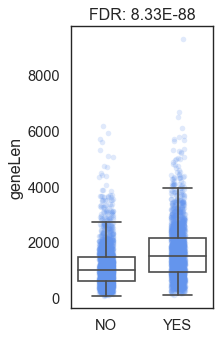

In [33]:
sns.set(font_scale=1.2)
sns.set_style("white")
plt.figure(figsize=(3, 4.5), dpi=80) 
ax = sns.stripplot(data=DF_imputed, x="has disordered region", y="geneLen", zorder=0, alpha=0.2, color='cornflowerblue')
#pv = ranksums(list(DF_imputed[DF_imputed['prion_inheritance'] == 1]['logFC']), list(DF_imputed[DF_imputed['prion_inheritance'] == 0]['logFC']))[1]
#pv = '%.2E' % Decimal(pv)
#ax.set(title='p-value: ' + pv)
fdr = '%.2E' % Decimal(geneLen_cat_ranksum.loc['has disordered region', 'FDR bh'])
ax.set(title='FDR: ' + fdr)
# plot boxplot
sns.boxplot(data=DF_imputed, x="has disordered region", y="geneLen", 
                 boxprops={'facecolor':'None'},
                 showfliers=False, ax=ax)
ax.set_xticklabels(['NO', 'YES'])
ax.set(xlabel=None)

plt.tight_layout()
#plt.savefig('plots/boxplot_dosageS_prion_inheritance.png')

# Wilcoxon rank sum test for Numeric features 

In [34]:
DF_imputed.columns[90:]

Index(['has transmembrane domain', 'flDPnn_disorder', 'PSIPRED_helix',
       'PSIPRED_strand', 'PSIPRED_coil', 'MMseq2_low_conservation',
       'MMseq2_high_conservation', 'MMseq2_median', 'SignalP',
       'DFLpred_linker', 'ASAquick_buried', 'DisoRDPbind_RNA',
       'DisoRDPbind_DNA', 'DisoRDPbind_PRO', 'MoRFchibi_morf', 'DRNApred_RNA',
       'DRNApred_DNA', 'SCRIBER_PRO', 'PTM_content', 'haploinsufficient',
       'Label', 'Numeric Label', 'rank', 'mitotic_cell_cycle',
       'cellular_morphology', 'regulation of mitotic cell cycle (GO:0007346)',
       'prion_inheritance', 'regulation of cell cycle process (GO:0010564)',
       'prions', 'Prion-like', 'Sphingolipid Metabolism_WP370',
       'number of genetic interaction', 'IDR ratio mean',
       'Phosphorylation number norm_geneLen',
       'Ubiquitilation number norm_geneLen',
       'variants_impact_MODERATE norm_geneLen',
       'variants_effect_missense_variant norm_geneLen',
       'variants_impact_LOW norm_geneLen',
   

In [35]:
num_list = ['geneLen', 'GC_content',
       'median_IUPRED', '%AA_A', '%AA_C', '%AA_D', '%AA_E', '%AA_F', '%AA_G',
       '%AA_H', '%AA_I', '%AA_K', '%AA_L', '%AA_M', '%AA_N', '%AA_P', '%AA_Q',
       '%AA_R', '%AA_S', '%AA_T', '%AA_V', '%AA_W', '%AA_Y', '%Helical',
       '%Proteinturn', '%Beta-sheet', 'Acidic AA%', 'Basic AA%', 'Polar AA%',
       'Hydrophobic AA%', 'Charged AA%', 'number of physical interaction',
       'number of positive genetic interaction',
       'number of negative genetic interaction', 'number of ppi, all',
       'number of ppi, score >= 0.25', 'number of ppi, score > 0.5',
       'number of ppi, score > 0.8', 'number of ppi, score >= 0.95',
       'RNAseq Eupl', 'rna logFC', 'rna FC - other', 'Imputed log2(MS)',
       'Ribo_profilling_init_rate', 'Ribo_profilling_trans_rate', 'IDR ratio',
       'Number of complexe', 'Intron status', 'aliphaticIndex',
       'aromaticityScore', 'cai', 'codonBias', 'gravyScore',
       'instabilityIndex', 'pI', "5'-UTR_length", "3'-UTR_length",
       'protein half-life (hr)', 'mRNA half-life (min)',
       'Ubiquitilation number', 'Phosphorylation number', 'variants_impact_HIGH', 'variants_impact_LOW',
       'variants_impact_MODERATE', 'variants_impact_MODIFIER',
       'variants_effect_conservative_inframe_deletion',
       'variants_effect_conservative_inframe_insertion',
       'variants_effect_disruptive_inframe_deletion',
       'variants_effect_disruptive_inframe_insertion',
       'variants_effect_downstream_gene_variant',
       'variants_effect_frameshift_variant', 'variants_effect_intron_variant',
       'variants_effect_missense_variant',
       'variants_effect_splice_region_variant', 'variants_effect_start_lost',
       'variants_effect_stop_gained', 'variants_effect_stop_lost',
       'variants_effect_stop_retained_variant',
       'variants_effect_synonymous_variant',
       'variants_effect_upstream_gene_variant', 'alpha IDRratio',
       'A3D mean score', 'A3D ratio', 'A3D mean +score',
       'flDPnn_disorder', 'PSIPRED_helix',
       'PSIPRED_strand', 'PSIPRED_coil', 'MMseq2_low_conservation',
       'MMseq2_high_conservation', 'MMseq2_median', 'SignalP',
       'DFLpred_linker', 'ASAquick_buried', 'DisoRDPbind_RNA',
       'DisoRDPbind_DNA', 'DisoRDPbind_PRO', 'MoRFchibi_morf', 'DRNApred_RNA',
       'DRNApred_DNA', 'SCRIBER_PRO', 'PTM_content',
       'number of genetic interaction', 'IDR ratio mean',
       'Phosphorylation number norm_geneLen',
       'Ubiquitilation number norm_geneLen',
       'variants_impact_MODERATE norm_geneLen',
       'variants_effect_missense_variant norm_geneLen',
       'variants_impact_LOW norm_geneLen',
       'variants_effect_synonymous_variant norm_geneLen']
pval = []
stat = []
for cat in num_list:
    rs = ranksums(list(DF_imputed[DF_imputed.Label == 'Toxic'][cat]), list(DF_imputed[DF_imputed.Label == 'Neutral'][cat]))
    pval.append(rs.pvalue)
    stat.append(rs.statistic)
    
num_ranksum = pd.DataFrame(list(zip(pval, stat)), index=num_list, columns=['p-value', 'Statistic'])
num_ranksum = num_ranksum.sort_values(by=['p-value'], ascending=True)

In [36]:
# fdr benjamini hochberg correction
from statsmodels.stats.multitest import multipletests
corr = multipletests(np.array(num_ranksum['p-value']), alpha=0.05, method='fdr_bh')
num_ranksum['FDR bh'] = corr[1]

In [37]:
num_ranksum[num_ranksum.index.isin(['number of ppi, all',
       'number of ppi, score >= 0.25', 'number of ppi, score > 0.5',
       'number of ppi, score > 0.8', 'number of ppi, score >= 0.95'])]

,p-value,Statistic,FDR bh
"number of ppi, score >= 0.95",0.133631,-1.499935,0.383791
"number of ppi, score > 0.8",0.379767,-0.878325,0.737853
"number of ppi, all",0.389218,0.861037,0.737853
"number of ppi, score >= 0.25",0.479407,0.707257,0.775511
"number of ppi, score > 0.5",0.917744,-0.103276,0.996167


In [38]:
num_ranksum[num_ranksum['FDR bh'] <= 0.1]

,p-value,Statistic,FDR bh
geneLen,1.545692e-25,10.444930,1.700261e-23
variants_effect_synonymous_variant,4.469634e-15,7.841003,1.419159e-13
variants_impact_LOW,4.515263e-15,7.839727,1.419159e-13
variants_impact_MODERATE,5.160577e-15,7.822935,1.419159e-13
variants_effect_missense_variant,1.709095e-14,7.670813,3.760009e-13
Ribo_profilling_init_rate,6.681391e-09,-5.798743,1.224922e-07
Phosphorylation number,8.822659e-09,5.751937,1.386418e-07
Ribo_profilling_trans_rate,1.589398e-08,-5.651623,2.185422e-07
ASAquick_buried,5.981543e-08,5.419352,7.310775e-07
alpha IDRratio,1.137476e-06,4.866229,1.251224e-05


In [39]:
pars = DF[['5UTR_PARS_RNAstructure', 'CDS_PARS_RNAstructure',
       '3UTR_PARS_RNAstructure', 'Label']].dropna()

l = ['5UTR_PARS_RNAstructure', 'CDS_PARS_RNAstructure', '3UTR_PARS_RNAstructure']
pval = []
stat = []
for cat in l:
    rs = ranksums(list(pars[pars.Label == 'Toxic'][cat]), list(pars[pars.Label == 'Neutral'][cat]))
    pval.append(rs.pvalue)
    stat.append(rs.statistic)
    
pars_ranksum = pd.DataFrame(list(zip(pval, stat)), index=l, columns=['p-value', 'Statistic'])
pars_ranksum = pars_ranksum.sort_values(by=['p-value'], ascending=True)

In [40]:
pars_ranksum

,p-value,Statistic
CDS_PARS_RNAstructure,0.000840,3.339276
3UTR_PARS_RNAstructure,0.009870,2.580341
5UTR_PARS_RNAstructure,0.431533,0.786571


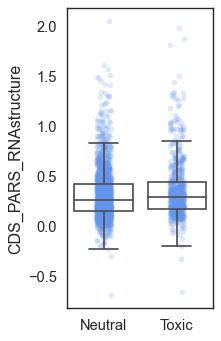

In [41]:
sns.set(font_scale=1.2)
sns.set_style("white")
plt.figure(figsize=(3, 4.5), dpi=80) 
ax = sns.stripplot(data=pars, x="Label", y="CDS_PARS_RNAstructure", zorder=0, alpha=0.2, color='cornflowerblue')
# plot boxplot
sns.boxplot(data=pars, x="Label", y="CDS_PARS_RNAstructure", 
                 boxprops={'facecolor':'None'},
                 showfliers=False, ax=ax)
#ax.set_xticklabels(['NO', 'YES'])
ax.set(xlabel=None)
plt.tight_layout()
#plt.savefig('plots/boxplot_dosageS_prion_inheritance.png')

In [42]:
num_ranksum[num_ranksum.index.isin(['number of physical interaction',
       'number of positive genetic interaction',
       'number of negative genetic interaction', 'number of ppi, all',
       'number of ppi, score >= 0.25', 'number of ppi, score > 0.5',
       'number of ppi, score > 0.8', 'number of ppi, score >= 0.95'])]

,p-value,Statistic,FDR bh
"number of ppi, score >= 0.95",0.133631,-1.499935,0.383791
number of physical interaction,0.328494,0.977151,0.722687
"number of ppi, score > 0.8",0.379767,-0.878325,0.737853
"number of ppi, all",0.389218,0.861037,0.737853
"number of ppi, score >= 0.25",0.479407,0.707257,0.775511
number of positive genetic interaction,0.808742,-0.242049,0.996167
"number of ppi, score > 0.5",0.917744,-0.103276,0.996167
number of negative genetic interaction,0.977220,0.028554,0.996167


In [43]:
num_ranksum.to_csv('result_datasets/wilcoxon_test_numerical.csv')

C:\Users\user\AppData\Local\Temp\ipykernel_13060\3553910590.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp['colors'] = ['red' if float( x) < 0 else 'green' for x in tmp['Statistic']]
C:\Users\user\AppData\Local\Temp\ipykernel_13060\3553910590.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp.sort_values('Statistic', ascending=True, inplace=True)
meta NOT subset; don't know how to subset; dropped


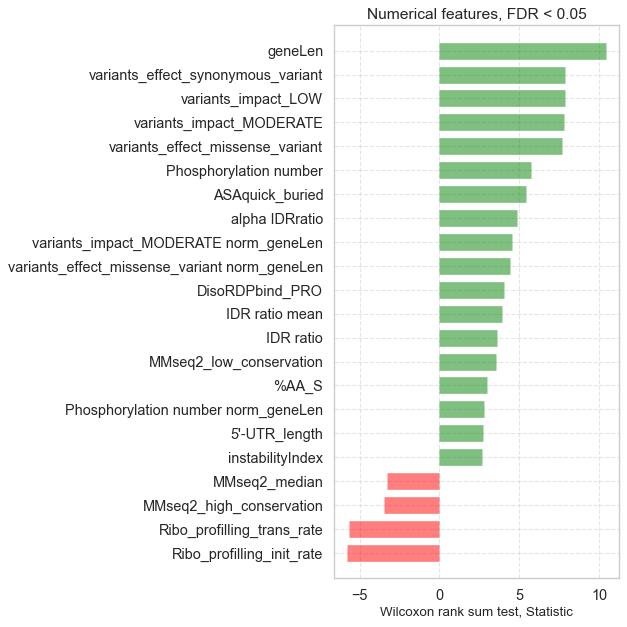

In [44]:
sns.set(font_scale=1)
sns.set_style("whitegrid")

tmp = num_ranksum[num_ranksum['FDR bh'] <= 0.05]
tmp['colors'] = ['red' if float( x) < 0 else 'green' for x in tmp['Statistic']] 

# Sort values from lowest to highest 
tmp.sort_values('Statistic', ascending=True, inplace=True) 

# Resets initial index in Dataframe to None 
#tmp.reset_index(inplace=True) 

# Draw plot 
plt.figure(figsize=(8, 8), dpi=80) 
# Plotting the horizontal lines 
plt.hlines(y=tmp.index, xmin=0, xmax=tmp['Statistic'], color=tmp.colors, alpha=0.5, linewidth=15) 

# Decorations 
# Setting the labels of x-axis and y-axis 
plt.gca().set(xlabel='Wilcoxon rank sum test, Statistic') 

# Setting Date to y-axis 
plt.yticks(tmp.index, fontsize=13) 
plt.xticks(fontsize=13) 

plt.title('Numerical features, FDR < 0.05', fontsize= 14) 
# Optional grid layout 
plt.grid(linestyle='--', alpha=0.5) 

# Displaying the Diverging Bar Chart 
plt.tight_layout()
plt.savefig('plots/plot_wilcoxon_fdr005_test.pdf')
plt.show() 

# Partial correlation
https://pingouin-stats.org/build/html/generated/pingouin.partial_corr.html#pingouin.partial_corr

In [45]:
pg.partial_corr(data=DF_imputed, x='logFC', y='ASAquick_buried', y_covar='geneLen', method='spearman').round(3)

,n,r,CI95%,p-val
spearman,4200,0.041,"[0.01, 0.07]",0.008


In [46]:
pg.partial_corr(data=DF_imputed, x='Numeric Label', y='Phosphorylation number', y_covar='geneLen', method='spearman').round(3)

,n,r,CI95%,p-val
spearman,4200,0.025,"[-0.01, 0.06]",0.102


In [47]:
S_corr = pg.pairwise_corr(df_short, method='spearman', padjust='fdr_bh', columns = 'Numeric Label').round(3)

In [48]:
S_corr = S_corr.sort_values('r')
S_corr[S_corr['p-corr'] < 0.05]

,X,Y,method,alternative,n,r,CI95%,p-unc,p-corr,p-adjust,power
108,Numeric Label,rank,spearman,two-sided,4200,-0.768,"[-0.78, -0.76]",0.000,0.000,fdr_bh,1.000
0,Numeric Label,logFC,spearman,two-sided,4200,-0.737,"[-0.75, -0.72]",0.000,0.000,fdr_bh,1.000
1,Numeric Label,FDR,spearman,two-sided,4200,-0.543,"[-0.56, -0.52]",0.000,0.000,fdr_bh,1.000
45,Numeric Label,Ribo_profilling_init_rate,spearman,two-sided,3856,-0.092,"[-0.12, -0.06]",0.000,0.000,fdr_bh,1.000
46,Numeric Label,Ribo_profilling_trans_rate,spearman,two-sided,3856,-0.090,"[-0.12, -0.06]",0.000,0.000,fdr_bh,1.000
63,Numeric Label,is essential,spearman,two-sided,4200,-0.059,"[-0.09, -0.03]",0.000,0.001,fdr_bh,0.970
94,Numeric Label,MMseq2_high_conservation,spearman,two-sided,4200,-0.053,"[-0.08, -0.02]",0.001,0.003,fdr_bh,0.934
95,Numeric Label,MMseq2_median,spearman,two-sided,4200,-0.050,"[-0.08, -0.02]",0.001,0.005,fdr_bh,0.904
30,Numeric Label,Polar AA%,spearman,two-sided,4200,0.039,"[0.01, 0.07]",0.011,0.043,fdr_bh,0.716
55,Numeric Label,instabilityIndex,spearman,two-sided,4200,0.041,"[0.01, 0.07]",0.008,0.033,fdr_bh,0.753


In [49]:
tmp = DF[['Ribo_profilling_init_rate', 'geneLen']]
tmp['log initiation rate'] = np.log2(tmp['Ribo_profilling_init_rate'])
tmp['log gene length'] = np.log2(tmp['geneLen'])
tmp.dropna(inplace=True)

C:\Users\user\AppData\Local\Temp\ipykernel_13060\2396197598.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp['log initiation rate'] = np.log2(tmp['Ribo_profilling_init_rate'])
C:\Users\user\AppData\Local\Temp\ipykernel_13060\2396197598.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp['log gene length'] = np.log2(tmp['geneLen'])
C:\Users\user\AppData\Local\Temp\ipykernel_13060\2396197598.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the ca

<Axes: xlabel='log gene length', ylabel='log initiation rate'>

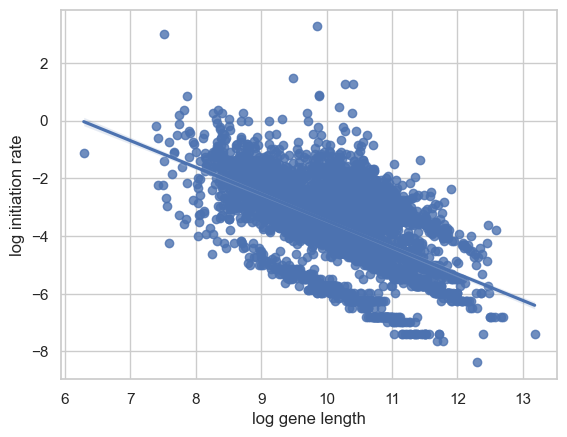

In [50]:
sns.regplot(data=tmp, y =  'log initiation rate', x='log gene length')

# Wilcoxon rank sum test for categorical data

In [51]:
cat_list = ['has disordered region', 'has transmembrane domain', 'haploinsufficient',  'mitotic_cell_cycle',
       'cellular_morphology', 'regulation of mitotic cell cycle (GO:0007346)',
       'prion_inheritance', 'regulation of cell cycle process (GO:0010564)',
       'prions', 'Sphingolipid Metabolism_WP370', 'is in complex', 'is essential', 'Intron status']
pval = []
stat = []
for cat in cat_list:
    rs = ranksums(list(DF_imputed[DF_imputed[cat] == 0]['logFC']), list(DF_imputed[DF_imputed[cat] == 1]['logFC']))
    pval.append(rs.pvalue)
    stat.append(rs.statistic)
    
cat_ranksum = pd.DataFrame(list(zip(pval, stat)), index=cat_list, columns=['p-value', 'Statistic'])
cat_ranksum = cat_ranksum.sort_values(by=['p-value'], ascending=True)
# FDR calculation
corr = multipletests(np.array(cat_ranksum['p-value']), alpha=0.05, method='fdr_bh')
cat_ranksum['FDR bh'] = corr[1]

In [52]:
cat_ranksum

,p-value,Statistic,FDR bh
has disordered region,1.722913e-11,6.727763,2.239787e-10
is essential,2.416858e-06,-4.715021,1.570958e-05
prion_inheritance,7.802031e-05,3.950401,3.380880e-04
regulation of cell cycle process (GO:0010564),5.573693e-04,3.451553,1.811450e-03
regulation of mitotic cell cycle (GO:0007346),8.462051e-04,3.337221,2.200133e-03
mitotic_cell_cycle,4.472094e-03,2.842787,9.689538e-03
Sphingolipid Metabolism_WP370,1.013814e-02,-2.571082,1.882797e-02
prions,4.118833e-02,2.041629,6.693103e-02
Intron status,7.212500e-02,-1.798328,1.041806e-01
has transmembrane domain,8.863154e-02,-1.702661,1.152210e-01


C:\Users\user\AppData\Local\Temp\ipykernel_13060\754083205.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp['colors'] = ['red' if float( x) < 0 else 'green' for x in tmp['Statistic']]
C:\Users\user\AppData\Local\Temp\ipykernel_13060\754083205.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp.sort_values('Statistic', ascending=True, inplace=True)
meta NOT subset; don't know how to subset; dropped


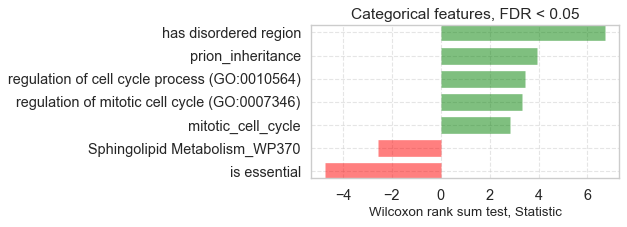

In [53]:
sns.set(font_scale=1)
sns.set_style("whitegrid")

tmp = cat_ranksum[cat_ranksum['FDR bh'] <= 0.05]
tmp['colors'] = ['red' if float( x) < 0 else 'green' for x in tmp['Statistic']] 

# Sort values from lowest to highest 
tmp.sort_values('Statistic', ascending=True, inplace=True) 

# Resets initial index in Dataframe to None 
#tmp.reset_index(inplace=True) 

# Draw plot 
plt.figure(figsize=(8, 3), dpi=80) 
# Plotting the horizontal lines 
plt.hlines(y=tmp.index, xmin=0, xmax=tmp['Statistic'], color=tmp.colors, alpha=0.5, linewidth=15) 

# Decorations 
# Setting the labels of x-axis and y-axis 
plt.gca().set(xlabel='Wilcoxon rank sum test, Statistic') 

# Setting Date to y-axis 
plt.yticks(tmp.index, fontsize=13) 
plt.xticks(fontsize=13) 

 
# Optional grid layout 
plt.grid(linestyle='--', alpha=0.5) 
plt.title('Categorical features, FDR < 0.05', fontsize= 14)
# Displaying the Diverging Bar Chart 
plt.tight_layout()
plt.savefig('plots/plot_wilcoxon_fdr005_categorical.pdf')
plt.show() 

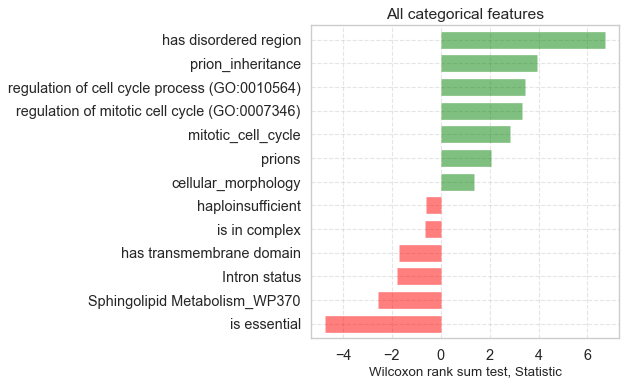

In [54]:
sns.set(font_scale=1)
sns.set_style("whitegrid")

tmp = cat_ranksum
tmp['colors'] = ['red' if float( x) < 0 else 'green' for x in tmp['Statistic']] 

# Sort values from lowest to highest 
tmp.sort_values('Statistic', ascending=True, inplace=True) 

# Resets initial index in Dataframe to None 
#tmp.reset_index(inplace=True) 

# Draw plot 
plt.figure(figsize=(8, 5), dpi=80) 
# Plotting the horizontal lines 
plt.hlines(y=tmp.index, xmin=0, xmax=tmp['Statistic'], color=tmp.colors, alpha=0.5, linewidth=15) 

# Decorations 
# Setting the labels of x-axis and y-axis 
plt.gca().set(xlabel='Wilcoxon rank sum test, Statistic') 

# Setting Date to y-axis 
plt.yticks(tmp.index, fontsize=13) 
plt.xticks(fontsize=13) 

 
# Optional grid layout 
plt.grid(linestyle='--', alpha=0.5) 
plt.title('All categorical features', fontsize= 14)
# Displaying the Diverging Bar Chart 
plt.tight_layout()
#plt.savefig('plots/plot_wilcoxon_fdr005_categorical.pdf')
plt.show() 

C:\Users\user\anaconda3\lib\site-packages\seaborn\matrix.py:1124: UserWarning: ``square=True`` ignored in clustermap
  warnings.warn(msg)
meta NOT subset; don't know how to subset; dropped


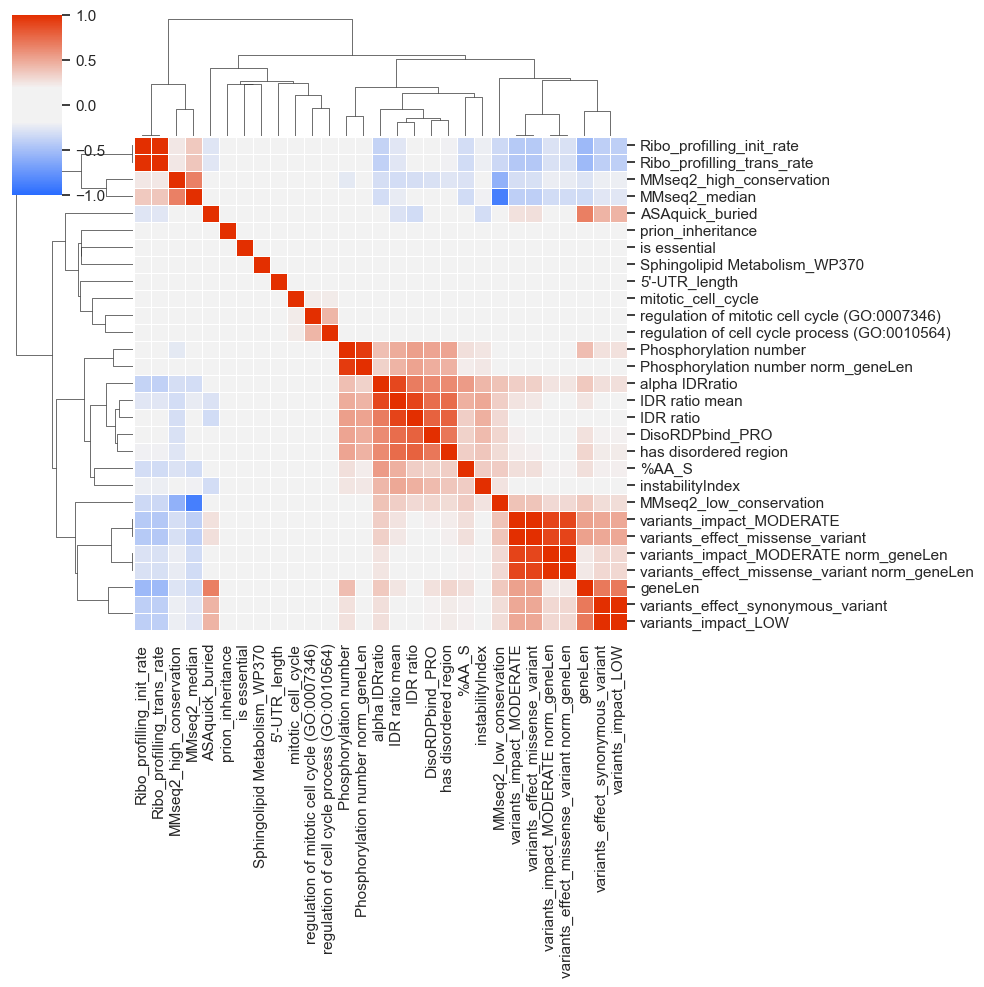

In [55]:
f = list(num_ranksum[num_ranksum['FDR bh'] <= 0.05].index) + list(cat_ranksum[cat_ranksum['FDR bh'] <= 0.05].index)
cmap = sns.diverging_palette(260, 15, s=100, as_cmap=True, sep=50)
corr = DF_imputed[f].corr(method='spearman')
sns.clustermap(corr, colors_ratio=1, cmap=cmap, yticklabels=True, figsize=(10,10),
               robust=False, vmin=-1, vmax=1, square = True, dendrogram_ratio=0.2, linewidths=.5)
plt.savefig('plots/heatmap_spearman_correlation_moby1_sign_features.pdf')

## Boxplot for significant numerical features

In [56]:
def numericalF_boxplot(feature, DF_imputed, num_ranksum, label = False):
    sns.set(font_scale=1.2)
    sns.set_style("white")
    plt.figure(figsize=(3, 4.5), dpi=80) 
    ax = sns.stripplot(data=DF_imputed, x="Label", y=feature, zorder=0, alpha=0.2, color='cornflowerblue')
    fdr = '%.2E' % Decimal(num_ranksum.loc[feature, 'FDR bh'])
    ax.set(title='FDR: ' + fdr)
    # plot boxplot
    sns.boxplot(data=DF_imputed, x="Label", y=feature, 
                     boxprops={'facecolor':'None'},
                     showfliers=False, ax=ax)

    ax.set(xlabel=None)
    if label:
        plt.ylabel(label)
    else:
        plt.ylabel(feature)
 
    plt.tight_layout()
    if label:
        plt.savefig('plots/moby_byophysicalF_boxplot/' + label + '.pdf')
    else:
        plt.savefig('plots/moby_byophysicalF_boxplot/' + feature + '.pdf')
    plt.close()

In [58]:
sign = ['geneLen', 'Ribo_profilling_init_rate', 'Ribo_profilling_trans_rate',
       'variants_impact_MODERATE norm_geneLen',
       'variants_effect_missense_variant norm_geneLen', 'IDR ratio',
       'Phosphorylation number norm_geneLen', '%AA_S']

sign_name = ['Gene Lenght', 'Ribosome profilling initiation rate', 'Ribosome profilling translation rate',
       'variants impact MODERATE normed to gene length',
       'variants effect missense variant normed to gene length', 'IDR ratio',
       'Phosphorylation number normed gene length', '%AA Serine']

for x in range(len(sign)):
    numericalF_boxplot(sign[x], DF_imputed, num_ranksum, sign_name[x])    

meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped


meta NOT subset; don't know how to subset; dropped


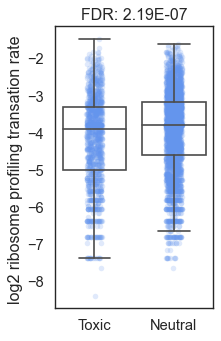

In [59]:
sns.set(font_scale=1.2)
sns.set_style("white")
plt.figure(figsize=(3, 4.5), dpi=80) 
#tmp = DF_imputed[DF_imputed['Ribo_profilling_init_rate'] < 7]
tmp = DF_imputed.copy()
tmp['Ribo_profilling_trans_rate'] = np.log2(tmp['Ribo_profilling_trans_rate'])
ax = sns.stripplot(data=tmp, x="Label", y="Ribo_profilling_trans_rate", zorder=0, alpha=0.2, color='cornflowerblue')

#pv = ranksums(list(DF_imputed[DF_imputed.Label == 'Toxic']['Ribo_profilling_init_rate']), list(DF_imputed[DF_imputed.Label == 'Neutral']['Ribo_profilling_init_rate']))[1]
#pv = '%.2E' % Decimal(pv)
#ax.set(title='p-value: ' + pv)
fdr = '%.2E' % Decimal(num_ranksum.loc['Ribo_profilling_trans_rate', 'FDR bh'])
ax.set(title='FDR: ' + fdr)

# plot boxplot
sns.boxplot(data=tmp, x="Label", y="Ribo_profilling_trans_rate", 
                 boxprops={'facecolor':'None'},
                 showfliers=False, ax=ax)
ax.set(xlabel=None)
plt.ylabel('log2 ribosome profiling transation rate ')

plt.tight_layout()
plt.savefig('plots/moby_byophysicalF_boxplot/boxplot_dosageS_RiboTransRate.pdf')
# 2 outliers removed

## Boxplot for significant categorical features. 

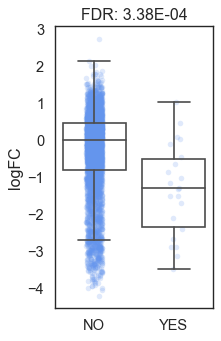

In [60]:
sns.set(font_scale=1.2)
sns.set_style("white")
plt.figure(figsize=(3, 4.5), dpi=80) 
ax = sns.stripplot(data=DF_imputed, x="prion_inheritance", y="logFC", zorder=0, alpha=0.2, color='cornflowerblue')
#pv = ranksums(list(DF_imputed[DF_imputed['prion_inheritance'] == 1]['logFC']), list(DF_imputed[DF_imputed['prion_inheritance'] == 0]['logFC']))[1]
#pv = '%.2E' % Decimal(pv)
#ax.set(title='p-value: ' + pv)
fdr = '%.2E' % Decimal(cat_ranksum.loc['prion_inheritance', 'FDR bh'])
ax.set(title='FDR: ' + fdr)
# plot boxplot
sns.boxplot(data=DF_imputed, x="prion_inheritance", y="logFC", 
                 boxprops={'facecolor':'None'},
                 showfliers=False, ax=ax)
ax.set_xticklabels(['NO', 'YES'])
ax.set(xlabel=None)

plt.tight_layout()
plt.savefig('plots/boxplot_dosageS_prion_inheritance.png')

## Combine positive and negative enrichment for categorical features (GSEA)

In [61]:
cat_ranksum = cat_ranksum[cat_ranksum['FDR bh'] <= 0.05]

pos = list(cat_ranksum[cat_ranksum['Statistic'] > 0].index)
neg = list(cat_ranksum[cat_ranksum['Statistic'] < 0].index)

DF_imputed['Combined +ES'] = DF_imputed[pos].any(axis=1).astype(int)
DF_imputed['Combined -ES'] = DF_imputed[neg].any(axis=1).astype(int)

DF_imputed['Sum +ES'] = DF_imputed[pos].sum(axis=1)
DF_imputed['Sum -ES'] = DF_imputed[neg].sum(axis=1)

In [62]:
DF_imputed['Cell cycle'] = DF_imputed[['mitotic_cell_cycle',
 'regulation of mitotic cell cycle (GO:0007346)',
 'regulation of cell cycle process (GO:0010564)']].any(axis=1).astype(int)

In [63]:
neg

['is essential', 'Sphingolipid Metabolism_WP370']

### Are new feature significant?

In [64]:
cat_list = ['has disordered region', 'has transmembrane domain', 'haploinsufficient',  'mitotic_cell_cycle',
       'cellular_morphology', 'regulation of mitotic cell cycle (GO:0007346)',
       'prion_inheritance', 'regulation of cell cycle process (GO:0010564)',
       'prions', 'Sphingolipid Metabolism_WP370', 'is in complex', 'is essential', 'Intron status', 
            'Cell cycle']
pval = []
stat = []
for cat in cat_list:
    rs = ranksums(list(DF_imputed[DF_imputed[cat] == 0]['logFC']), list(DF_imputed[DF_imputed[cat] == 1]['logFC']))
    pval.append(rs.pvalue)
    stat.append(rs.statistic)
    
cat_ranksum = pd.DataFrame(list(zip(pval, stat)), index=cat_list, columns=['p-value', 'Statistic'])
cat_ranksum = cat_ranksum.sort_values(by=['p-value'], ascending=True)
# FDR calculation
corr = multipletests(np.array(cat_ranksum['p-value']), alpha=0.05, method='fdr_bh')
cat_ranksum['FDR bh'] = corr[1]

C:\Users\user\AppData\Local\Temp\ipykernel_13060\573581631.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp['colors'] = ['red' if float( x) < 0 else 'green' for x in tmp['Statistic']]
C:\Users\user\AppData\Local\Temp\ipykernel_13060\573581631.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp.sort_values('Statistic', ascending=True, inplace=True)
meta NOT subset; don't know how to subset; dropped


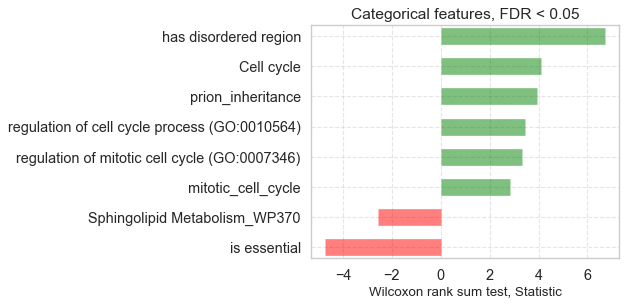

In [65]:
sns.set(font_scale=1)
sns.set_style("whitegrid")

tmp = cat_ranksum[cat_ranksum['FDR bh'] <= 0.05]
tmp['colors'] = ['red' if float( x) < 0 else 'green' for x in tmp['Statistic']] 

# Sort values from lowest to highest 
tmp.sort_values('Statistic', ascending=True, inplace=True) 

# Resets initial index in Dataframe to None 
#tmp.reset_index(inplace=True) 

# Draw plot 
plt.figure(figsize=(8, 4), dpi=80) 
# Plotting the horizontal lines 
plt.hlines(y=tmp.index, xmin=0, xmax=tmp['Statistic'], color=tmp.colors, alpha=0.5, linewidth=15) 

# Decorations 
# Setting the labels of x-axis and y-axis 
plt.gca().set(xlabel='Wilcoxon rank sum test, Statistic') 

# Setting Date to y-axis 
plt.yticks(tmp.index, fontsize=13) 
plt.xticks(fontsize=13) 

 
# Optional grid layout 
plt.grid(linestyle='--', alpha=0.5) 
plt.title('Categorical features, FDR < 0.05', fontsize= 14)
# Displaying the Diverging Bar Chart 
plt.tight_layout()
plt.savefig('plots/plot_wilcoxon_fdr005_categorical.pdf')
plt.show() 

# Classifier
https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html

In [66]:
def train_model(DF, num_F, cat_F, y_F, model):
    folds = StratifiedKFold(5,shuffle=True,random_state=17)
    scores = []
    scoresT = []
    X = DF[num_F+cat_F]
    y = DF[y_F]
    
    for fold_n, (train_index, valid_index) in enumerate(folds.split(X, y)):
        X_train = X.iloc[train_index]
        X_valid = X.iloc[valid_index]
        y_train = y.iloc[train_index]
        y_valid = y.iloc[valid_index]
        # scaling
        scaler = preprocessing.StandardScaler().fit(X_train[num_F])
        X_train_s = pd.DataFrame(scaler.fit_transform(X_train[num_F]), columns=num_F, index = list(X_train.index))
        X_valid_s = pd.DataFrame(scaler.transform(X_valid[num_F]), columns=num_F, index = list(X_valid.index))
        X_train_s = pd.concat([X_train_s, X_train[cat_F]], axis=1)
        X_valid_s = pd.concat([X_valid_s, X_valid[cat_F]], axis=1)

        # fitting
        model.fit(X_train_s, y_train)
        # test set prediction and evalution 
        y_pred_valid = model.predict_proba(X_valid_s)
        # retrieve just the probabilities for the positive class
        y_pred_valid = y_pred_valid[:, 1]
        fpr, tpr, thresholds = metrics.roc_curve(np.array(y_valid), y_pred_valid, pos_label=1)

        scores.append(metrics.auc(fpr, tpr))
        
        # Train set fitting to check overfeating
        y_pred = model.predict_proba(X_train_s)
        # retrieve just the probabilities for the positive class
        y_pred = y_pred[:, 1]
        fpr, tpr, thresholds = metrics.roc_curve(np.array(y_train), y_pred, pos_label=1)
        scoresT.append(metrics.auc(fpr, tpr))
    return np.mean(scoresT),  np.mean(scores)

## ROC curve with cross validation
https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc_crossval.html

In [67]:
def CV_roc_curve(DF, num_F, cat_F, y_F, fig, ax, n_splits, model, color, label_name, linestyle='solid'):
    folds = StratifiedKFold(n_splits,shuffle=True,random_state=17)
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    
    X = DF[num_F+cat_F]
    y = DF[y_F]
    
    for fold, (train_index, valid_index) in enumerate(folds.split(X, y)):
        X_train = X.iloc[train_index]
        X_valid = X.iloc[valid_index]
        y_train = y.iloc[train_index]
        y_valid = y.iloc[valid_index]
        # scaling
        scaler = preprocessing.StandardScaler().fit(X_train[num_F])
        X_train_s = pd.DataFrame(scaler.fit_transform(X_train[num_F]), columns=num_F, index = list(X_train.index))
        X_valid_s = pd.DataFrame(scaler.transform(X_valid[num_F]), columns=num_F, index = list(X_valid.index))

        # merge scaled numerical and categorical
        X_train = pd.concat([X_train_s, X_train[cat_F]], axis=1)
        X_valid = pd.concat([X_valid_s, X_valid[cat_F]], axis=1)

        # fitting
        model.fit(X_train, y_train)
            
        viz = RocCurveDisplay.from_estimator(model, X_valid, y_valid, name=f"ROC fold {fold}",alpha=0,
                lw=1, ax=ax, plot_chance_level=(fold == n_splits - 1))
        interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(viz.roc_auc)
      
        # same aucs calculation as train_model function
        y_pred_valid = model.predict_proba(X_valid)
        # retrieve just the probabilities for the positive class
        y_pred_valid = y_pred_valid[:, 1]
        f, t, thresholds = metrics.roc_curve(np.array(y_valid), y_pred_valid, pos_label=1)
        aucs.append(metrics.auc(f, t))
        

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = np.mean(aucs)
    std_auc = np.std(aucs)
    ax.plot(mean_fpr,mean_tpr,color=color, linestyle=linestyle, label= label_name + r", Mean ROC (AUC = %0.3f $\pm$ %0.3f)" % (mean_auc, std_auc),
        lw=2,alpha=0.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(
        mean_fpr,
        tprs_lower,
        tprs_upper,
        color=color,
        alpha=0.1,
        label=r"$\pm$ std. dev.")
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    return model, scaler

In [68]:
def CV_confusion(DF,  num_F, cat_F, y_F, model, n_splits, normalize='true', list_labels=['Neutral', 'DS']):
    folds = StratifiedKFold(n_splits,shuffle=True,random_state=17)
    y_comb = []
    pred_comb = []
    
    X = DF[num_F+cat_F]
    y = DF[y_F]
    
    for fold_n, (train_index, test_index) in enumerate(folds.split(X, y)):
        X_train = X.iloc[train_index]
        X_test = X.iloc[test_index]
        y_train = y.iloc[train_index]
        y_test = y.iloc[test_index]
        # scaling
        scaler = preprocessing.StandardScaler().fit(X_train[num_F])
        X_train_s = scaler.transform(X_train[num_F])
        X_test_s = scaler.transform(X_test[num_F])
        X_train_s = pd.DataFrame(scaler.fit_transform(X_train[num_F]), columns=num_F, index = list(X_train.index))
        X_test_s = pd.DataFrame(scaler.transform(X_test[num_F]), columns=num_F, index = list(X_test.index))
        
        X_train = pd.concat([X_train_s, X_train[cat_F]], axis=1)
        X_test = pd.concat([X_test_s, X_test[cat_F]], axis=1)

        # model
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        y_comb += list(y_test)
        pred_comb += list(y_pred)

    cm = confusion_matrix(np.array(y_comb), np.array(pred_comb), normalize=normalize)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list_labels)
    fig, ax = plt.subplots(figsize=(3.5,3.5))
    ax.grid(False)
    disp.plot(ax=ax, cmap= 'Blues')

In [69]:
def test_set_checking(DF, num_F, cat_F, y_F, model, n_splits, feature = 'logFC'):
    folds = StratifiedKFold(n_splits,shuffle=True,random_state=17)
    
    models = []
    valid_sets = []
    X = DF[num_F+cat_F]
    y = DF[y_F]
    
    for fold_n, (train_index, valid_index) in enumerate(folds.split(X, y)):
        X_train = X.iloc[train_index]
        X_valid = X.iloc[valid_index]
        y_train = y.iloc[train_index]
        y_valid = y.iloc[valid_index]
        # scaling
        scaler = preprocessing.StandardScaler().fit(X_train[num_F])
        X_train_s = pd.DataFrame(scaler.fit_transform(X_train[num_F]), columns=num_F, index = list(X_train.index))
        X_valid_s = pd.DataFrame(scaler.transform(X_valid[num_F]), columns=num_F, index = list(X_valid.index))
        X_train_s = pd.concat([X_train_s, X_train[cat_F]], axis=1)
        X_valid_s = pd.concat([X_valid_s, X_valid[cat_F]], axis=1)

        # fitting
        model.fit(X_train, y_train)
    
        # Compare genes properly categorize and the rest
        pred_valid = model.predict(X_valid)
        y_true_pred = y_valid.to_frame()
        y_true_pred['LR pred'] = pred_valid
        y_true_pred['sum'] = y_true_pred['Numeric Label'] + y_true_pred['LR pred']

        false = y_true_pred[y_true_pred['sum'] == 1]
        true = y_true_pred[y_true_pred['sum'] == 2]

        false_10 = false[false['Numeric Label'] == 1]
        false_01 = false[false['Numeric Label'] == 0]

        true = DF_imputed[DF_imputed.index.isin(list(true.index))]
        false_10 = DF_imputed[DF_imputed.index.isin(list(false_10.index))]
        false_01 = DF_imputed[DF_imputed.index.isin(list(false_01.index))]

        valid_set = DF_imputed[DF_imputed.index.isin(list(y_true_pred.index))]

            # create a list of our conditions
        conditions = [
            (valid_set.index.isin(list(true.index))),
            (valid_set.index.isin(list(false_01.index))),
            (valid_set.index.isin(list(false_10.index))), 
            ]

        # create a list of the values we want to assign for each condition
        values = ['True positive', 'False positive', 'False negative']

        # create a new column and use np.select to assign values to it using our lists as arguments
        valid_set['classifier'] = np.select(conditions, values, default='True negative')
        
        valid_sets.append(valid_set)
    
    valid_set = valid_sets[0]
    for x in range(1, len(valid_sets)):
        valid_set = pd.concat([valid_set, valid_sets[x]], axis=0)
        
    sns.set(font_scale=1.2)
    sns.set_style("white")
    plt.figure(figsize=(4, 5), dpi=80) 
    ax = sns.stripplot(data=valid_set, x="classifier", y=feature, alpha=0.3, color='cornflowerblue', 
                       order=['True positive', 'False positive', 'True negative', 'False negative'])
    #fdr = '%.2E' % Decimal(num_ranksum.loc['IDR ratio', 'FDR bh'])
    #ax.set(title='FDR: ' + fdr)
    # plot boxplot
    sns.boxplot(data=valid_set, x="classifier", y=feature, 
                order = ['True positive', 'False positive', 'True negative', 'False negative'],
                     boxprops={'facecolor':'None'},
                     showfliers=False, ax=ax)
    ax.set(xlabel=None)
    medians = valid_set.groupby(['classifier'])[feature].median()
    vertical_offset = valid_set[feature].median() * 0.05 # offset from median for display

    t=0
    for xtick in ['True positive', 'False positive', 'True negative', 'False negative']: 
        ax.text(t, medians[xtick], '%.2f' % medians[xtick], 
                horizontalalignment='center')
        t+=1
    plt.xticks(rotation=90)
    plt.tight_layout()

In [70]:
# function to get the coefficient of model across k-fold
def coefs_kfold(DF, num_F, cat_F, y_F, n_splits, model):
    folds = StratifiedKFold(n_splits,shuffle=True,random_state=17)
    X = DF[num_F+cat_F]
    y = DF[y_F]
    
    for fold, (train_index, valid_index) in enumerate(folds.split(X, y)):
        X_train = X.iloc[train_index]
        X_valid = X.iloc[valid_index]
        y_train = y.iloc[train_index]
        y_valid = y.iloc[valid_index]
        # scaling
        scaler = preprocessing.StandardScaler().fit(X_train[num_F])
        X_train_s = pd.DataFrame(scaler.fit_transform(X_train[num_F]), columns=num_F, index = list(X_train.index))
        X_valid_s = pd.DataFrame(scaler.transform(X_valid[num_F]), columns=num_F, index = list(X_valid.index))
        X_train_s = pd.concat([X_train_s, X_train[cat_F]], axis=1)
        X_valid_s = pd.concat([X_valid_s, X_valid[cat_F]], axis=1)

        # Back to dataframe
        X_train = pd.DataFrame(X_train_s, index=X_train.index, columns=X_train.columns)
        X_valid = pd.DataFrame(X_valid_s, index=X_valid.index, columns=X_valid.columns)

        # fitting
        model.fit(X_train, y_train)
            
        if fold == 0:
            tmp = pd.DataFrame(model.coef_[0], columns=[fold], index= list(X_train.columns))
        else:
            tmp[fold] = model.coef_[0]
            
    tmp['mean'] = tmp.mean(axis=1)
    tmp['std'] =tmp.std(axis=1)

    return tmp

In [71]:
# function to get the coefficient of model across k-fold
def permutation_importance_kfold(DF, num_F, cat_F, y_F, n_splits, model, n_repeats= 10, scoring= None):
    folds = StratifiedKFold(n_splits,shuffle=True,random_state=42, )
    X = DF[num_F+cat_F]
    y = DF[y_F]
    
    for fold, (train_index, valid_index) in enumerate(folds.split(X, y)):
        X_train = X.iloc[train_index]
        X_valid = X.iloc[valid_index]
        y_train = y.iloc[train_index]
        y_valid = y.iloc[valid_index]
        # scaling
        scaler = preprocessing.StandardScaler().fit(X_train[num_F])
        X_train_s = pd.DataFrame(scaler.fit_transform(X_train[num_F]), columns=num_F, index = list(X_train.index))
        X_valid_s = pd.DataFrame(scaler.transform(X_valid[num_F]), columns=num_F, index = list(X_valid.index))
        X_train_s = pd.concat([X_train_s, X_train[cat_F]], axis=1)
        X_valid_s = pd.concat([X_valid_s, X_valid[cat_F]], axis=1)

        # Back to dataframe
        X_train = pd.DataFrame(X_train_s, index=X_train.index, columns=X_train.columns)
        X_valid = pd.DataFrame(X_valid_s, index=X_valid.index, columns=X_valid.columns)

        # fitting
        model.fit(X_train, y_train)
        result = permutation_importance(model, X_train, y_train, n_repeats=n_repeats, random_state=42, scoring=scoring)
        
        if fold == 0:
            tmp = pd.DataFrame(result.importances_mean, columns=[fold], index= list(X_train.columns))
        else:
            tmp[fold] = result.importances_mean
            
    tmp['mean'] = tmp.mean(axis=1)
    tmp['std'] =tmp.std(axis=1)

    return tmp

In [72]:
def corr_features(X, coef= 'spearman', filename= False):
    corr = X.corr(method=coef)
    # Generate a mask for the upper triangle
    mask = np.zeros_like(corr, dtype=bool)
    mask[np.triu_indices_from(mask)] = True
    # Set up the matplotlib figure
    fig, ax = plt.subplots(figsize=(14, 9))
    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True, sep=100)
    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, vmin=-1, vmax=1, center=0, linewidths=.5, annot=True)
    plt.yticks(rotation=0) 
    fig.suptitle('Correlation matrix of features', fontsize=15)
    fig.tight_layout()
    if filename:
        fig.savefig(filename, bbox_inches='tight')

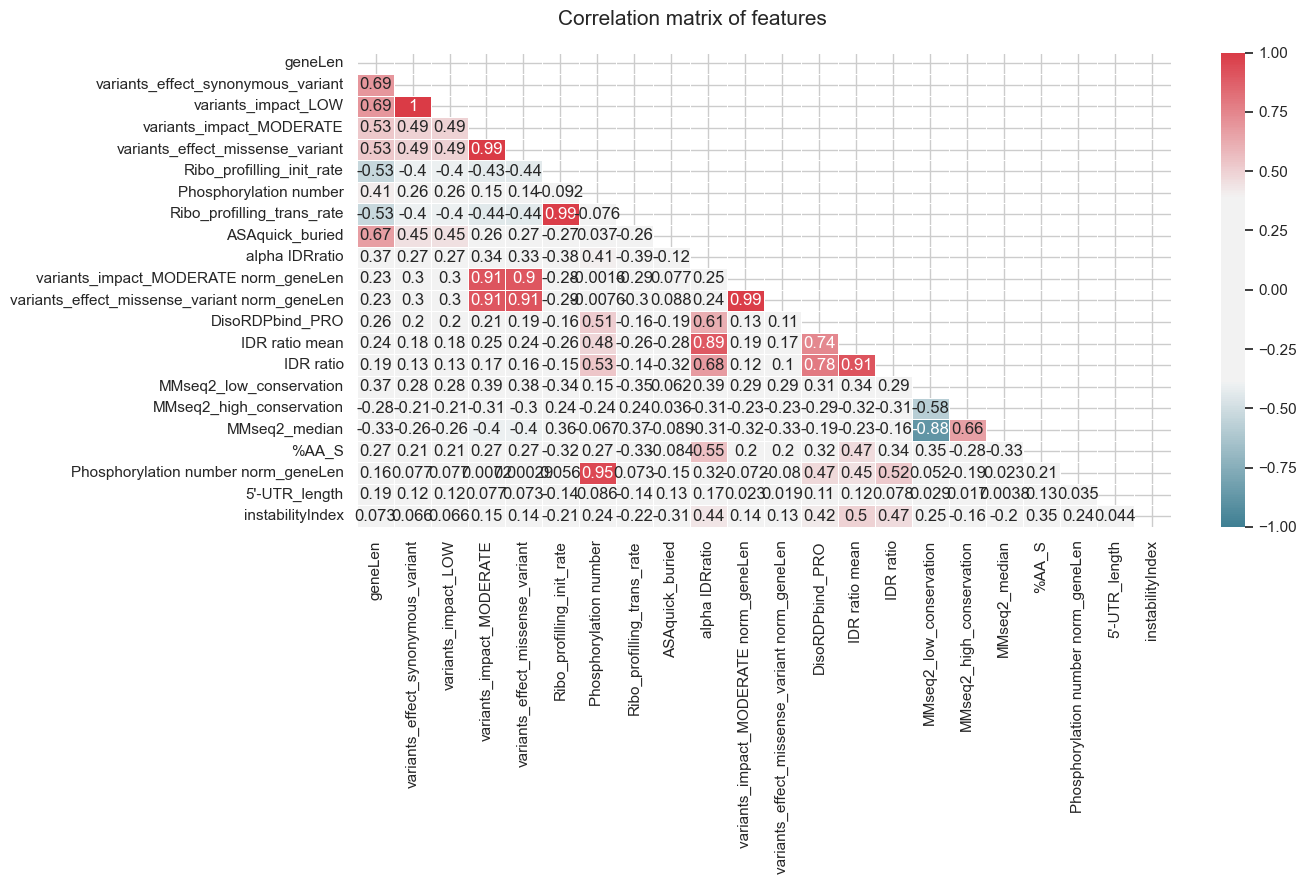

In [73]:
features = list(num_ranksum[num_ranksum['FDR bh'] <= 0.05].index)
corr_features(DF_imputed[features])

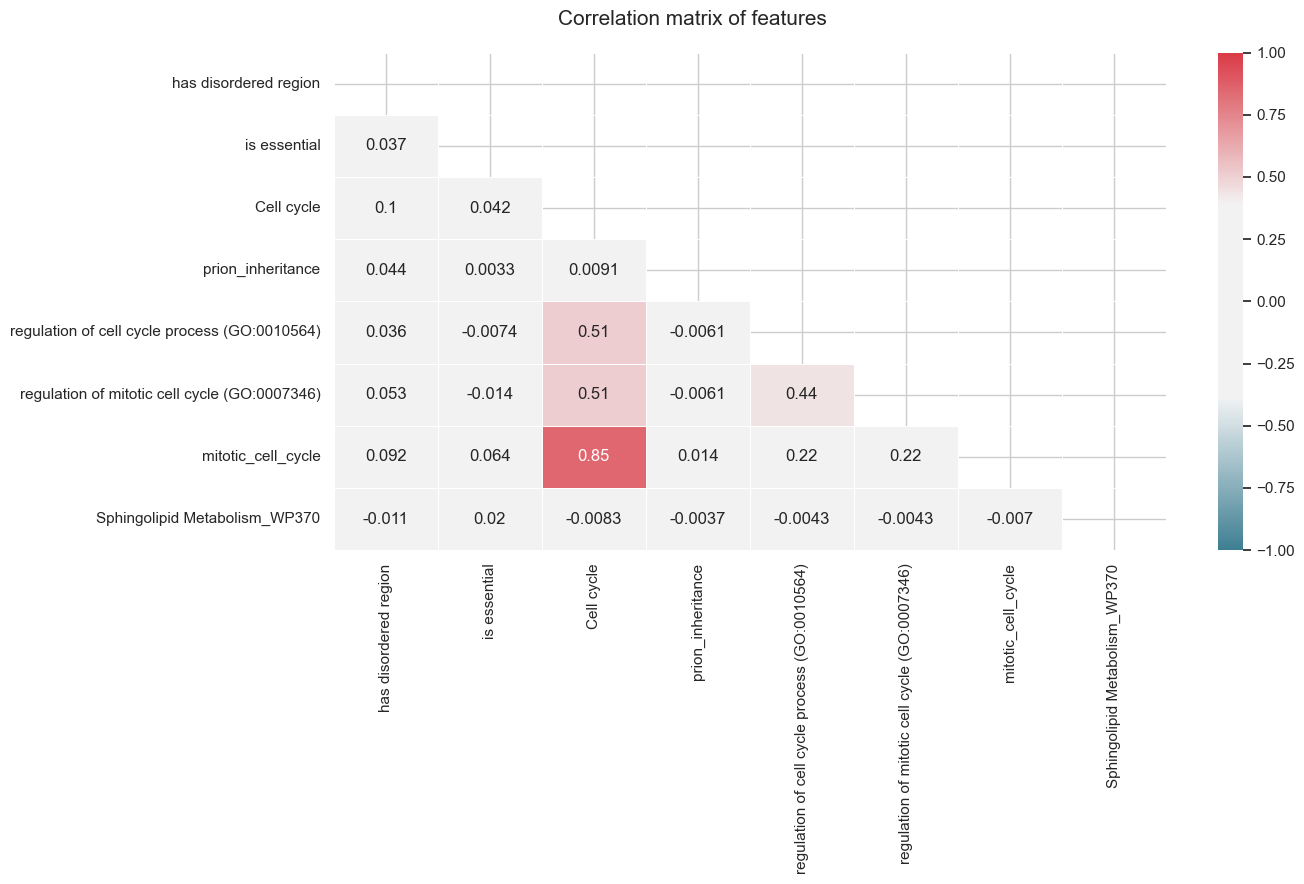

In [74]:
corr_features(DF_imputed[list(cat_ranksum[cat_ranksum['FDR bh'] < 0.05].index)])

In [75]:
def plot_coefs(coefs, display_fit = 10, dim = (8, 4), savefig= None):
    sns.set(font_scale=1)
    sns.set_style("whitegrid")

    coefs['colors'] = ['red' if float( x) < 0 else 'green' for x in coefs['mean']] 

    # Sort values from lowest to highest 
    coefs['abs mean'] = np.abs(coefs['mean'])
    coefs.sort_values('abs mean', inplace= True, ascending=False)

    tmp = coefs.head(display_fit)
    tmp.sort_values('mean', inplace=True)
    # Resets initial index in Dataframe to None 
    #tmp.reset_index(inplace=True) 

    # Draw plot 
    plt.figure(figsize=dim, dpi=80) 
    # Plotting the horizontal lines 
    plt.hlines(y=tmp.index, xmin=0, xmax=tmp['mean'], color=tmp.colors, alpha=0.5, linewidth=12) 
    plt.errorbar(x = tmp['mean'], y = tmp.index, xerr = tmp['std'], color='black', fmt='none', capsize=0)
    # Decorations 
    # Setting the labels of x-axis and y-axis 
    plt.gca().set(xlabel='Coefficients mean') 

    # Setting Date to y-axis 
    plt.yticks(tmp.index, fontsize=13) 
    plt.xticks(fontsize=13) 
 
    # Optional grid layout 
    plt.grid(linestyle='--', alpha=0.5) 
    plt.title('Logistic regression, 5-fold top features', fontsize= 14)
    plt.tight_layout()
    if savefig:
        plt.savefig(savefig)
    plt.show()       

In [76]:
list(cat_ranksum[cat_ranksum['FDR bh'] < 0.05].index)

['has disordered region',
 'is essential',
 'Cell cycle',
 'prion_inheritance',
 'regulation of cell cycle process (GO:0010564)',
 'regulation of mitotic cell cycle (GO:0007346)',
 'mitotic_cell_cycle',
 'Sphingolipid Metabolism_WP370']

In [77]:
# Num features with dfr <0.1, removed one of higly orrelated features
f_short_num =['geneLen',
 'Ribo_profilling_init_rate',
 'ASAquick_buried',
 'alpha IDRratio',
 'variants_impact_MODERATE norm_geneLen',
 'DisoRDPbind_PRO',
 'MMseq2_low_conservation',
 'MMseq2_high_conservation',
 'Phosphorylation number norm_geneLen',
 '%AA_S',
 "5'-UTR_length",
 'RNAseq Eupl',
 'instabilityIndex']

f_cat = ['has disordered region',
 'is essential',
 'Cell cycle',
 'prion_inheritance',
 'regulation of cell cycle process (GO:0010564)',
 'regulation of mitotic cell cycle (GO:0007346)',
 'Sphingolipid Metabolism_WP370']

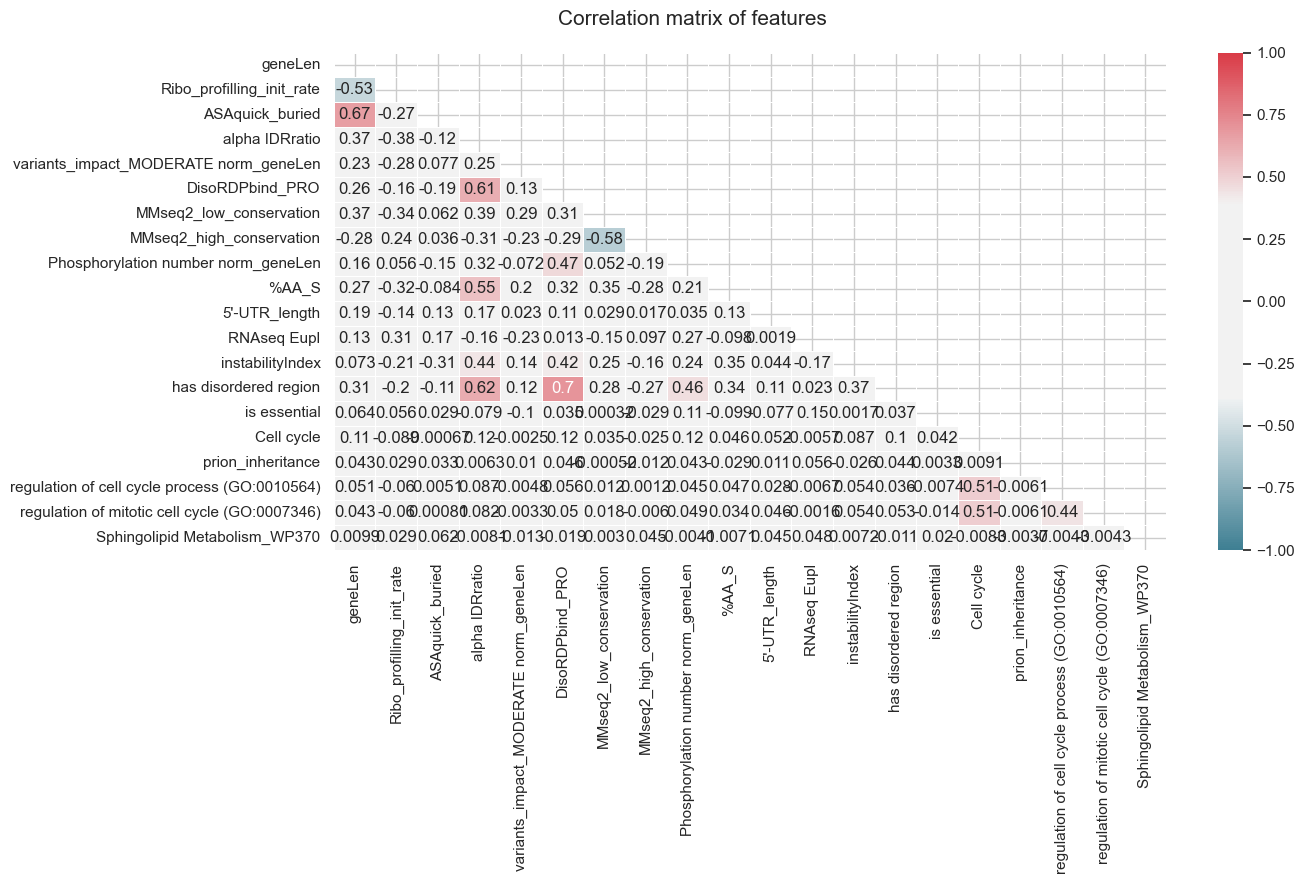

In [78]:
corr_features(DF_imputed[f_short_num + f_cat])

# Remove uncertain genes 

In [80]:
DF_filtered = DF_imputed.copy()
DF_filtered.drop(['Numeric Label', 'Label'], axis=1, inplace=True)
q15 = DF_imputed.logFC.quantile(.15)
# Conditions for genes to drop
c1 = DF_filtered[DF_filtered['logFC'] <= q15].index
c2 = DF_filtered[DF_filtered['FDR'] <= 0.05].index
toxic = list(set(c1) & set(c2)) 
DF_filtered['Label'] = 0
DF_filtered.loc[DF_filtered.index.isin(toxic), 'Label'] = 1
# drop the middle
q60 = DF_imputed.logFC.quantile(.65)
c3 = DF_filtered[DF_filtered['logFC'] < q60].index
to_drop = list(set(c3) - set(toxic))
DF_filtered = DF_filtered.drop(to_drop)

In [81]:
print('% toxic genes: ', DF_filtered['Label'].sum() / DF_filtered.shape[0] *100)
print('% neutral/beneficial genes: ', (DF_filtered.shape[0] - DF_filtered['Label'].sum()) / DF_filtered.shape[0] *100)

% toxic genes:  29.428708593374942
% neutral/beneficial genes:  70.57129140662506


In [82]:
q60

0.2722276822323903

In [83]:
DF_filtered.drop_duplicates(subset= 'Systematic name', inplace=True)

In [84]:
DF_filtered.set_index('Systematic name', inplace = True)

In [85]:
classifiers = ['LogisticRegression', 'Logit, newton-cholesky',  'RandomForestClassifier', 'GradientBoostingClassifier', 'XGBoostClassifier',]
models = [LogisticRegression(max_iter=500, penalty='elasticnet', C=0.05, l1_ratio=0.5, solver='saga', class_weight='balanced'),
          LogisticRegression(max_iter=500, penalty='l2', solver='newton-cholesky', class_weight='balanced'),
          RandomForestClassifier(n_estimators=100, min_samples_leaf=24, max_depth=8,
                                 random_state=17, class_weight='balanced', min_impurity_decrease= 0.01),
          GradientBoostingClassifier(n_estimators= 100, subsample= 0.8, random_state=17, min_impurity_decrease=4, 
                                     max_depth=6),
          xgb.XGBClassifier(n_estimators=100, scale_pos_weight=7, min_child_weight=250, subsample=0.8, max_depth=4)
         ]

for x in range(len(models)):
    score_T, score_V = train_model(DF_filtered, f_short_num, f_cat, 'Label', models[x])
    print(classifiers[x], ':')
    print('Train ROC, mean: ', score_T)
    print('Test ROC, mean: ', score_V)

LogisticRegression :
Train ROC, mean:  0.7114875343295803
Test ROC, mean:  0.6998359839737575
Logit, newton-cholesky :
Train ROC, mean:  0.7219988658832751
Test ROC, mean:  0.7011024161763866
RandomForestClassifier :
Train ROC, mean:  0.7058300990083052
Test ROC, mean:  0.6843666614986658
GradientBoostingClassifier :
Train ROC, mean:  0.7037457141924063
Test ROC, mean:  0.6908427105348338
XGBoostClassifier :
Train ROC, mean:  0.7307441368625259
Test ROC, mean:  0.673013017015416


In [86]:
def plot_FI(FI, f_display = 10, savefig=None):
    FI.sort_values('mean', inplace=True)
    FI = FI.tail(f_display)
    # Draw plot 
    plt.figure(figsize=(7, 4.5), dpi=80) 
    # Plotting the horizontal lines 
    plt.boxplot(
            FI[[0,1,2,3,4]].T,
            vert=False,
            labels=list(FI.index),
            widths= 0.8,
        patch_artist = True,
                boxprops=dict(color='black', facecolor = 'green', alpha = 0.5),
                capprops=dict(color='black'),
                whiskerprops=dict(color='black'),
                medianprops=dict(color='black')
        )
    plt.axvline(x=0, color="k", linestyle="--")

    # Decorations 
    # Setting the labels of x-axis and y-axis 
    plt.gca().set(xlabel='Mean feature importance') 

    # Setting Date to y-axis 
    plt.xticks(fontsize=13) 


    # Optional grid layout 
    plt.grid(linestyle='--', alpha=0.5) 
    plt.title('Logistic regression, 5-fold top features', fontsize= 14)
    # Displaying the Diverging Bar Chart 
    plt.tight_layout()
    if savefig:
        plt.savefig(savefig)
    plt.show() 

meta NOT subset; don't know how to subset; dropped


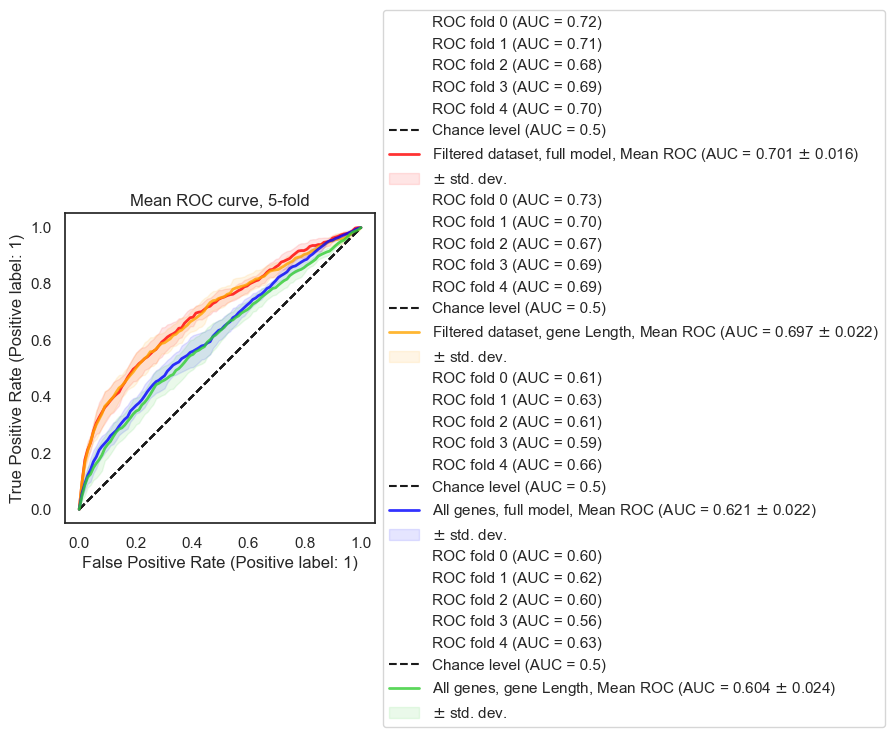

In [87]:
classifier = LogisticRegression(max_iter=500, penalty='l2', solver='newton-cholesky', class_weight='balanced')
sns.set_style("white")
fig, ax = plt.subplots(figsize=(4, 8))
ax.set(
        xlim=[-0.05, 1.05],
        ylim=[-0.05, 1.05],
        xlabel="False Positive Rate",
        ylabel="True Positive Rate",
        title=f"Mean ROC curve, 5-fold",
    )
ax.axis("square")

m1, s1 = CV_roc_curve(DF_filtered, f_short_num, f_cat, 'Label', fig, ax, 5, classifier, 'red', 'Filtered dataset, full model')
m2, s2 = CV_roc_curve(DF_filtered, ['geneLen'], [], 'Label', fig, ax, 5, classifier, 'orange', 'Filtered dataset, gene Length')

m1, s1 = CV_roc_curve(DF_imputed, f_short_num, f_cat, 'Numeric Label', fig, ax, 5, classifier, 'blue', 'All genes, full model')
m2, s2 = CV_roc_curve(DF_imputed, ['geneLen'], [], 'Numeric Label', fig, ax, 5, classifier, 'limegreen', 'All genes, gene Length')
plt.savefig('plots/LogisticRegression_5fold_ROCcurve_filtered.pdf')
plt.show()

In [88]:
def plot_FI_coef_col(FI, coef, f_display = 12, savefig=None, c1 = 'green', c2 = 'red', figsize = (10, 4.5)):
    FI.sort_values('mean', inplace=True)
    coef = coef.rename(columns={'mean': 'coef'})
    FI = FI.join(coef['coef'])
    FI = FI.tail(f_display)
    colors = []
    for c in list(FI['coef']):
        if c > 0:
            colors.append(c1)
        else:
            colors.append(c2)
            
    # Draw plot 
    fig = plt.figure(figsize =figsize)
    ax = fig.add_subplot(111)
    # Plotting the horizontal lines 
    bp = ax.boxplot(
            FI[[0,1,2,3,4]].T,
            vert=False,
            labels=list(FI.index),
            widths= 0.8,
        patch_artist = True,
                boxprops=dict(color='black', alpha = 0.5),
                capprops=dict(color='black'),
                whiskerprops=dict(color='black'),
                medianprops=dict(color='black'))
    
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_color(color)
       
    ax.axvline(x=0, color="k", linestyle="--")
    # Decorations 
    # Setting the labels of x-axis and y-axis 
    plt.gca().set(xlabel='Mean feature importance') 

    # Setting Date to y-axis 
    plt.xticks(fontsize=12) 
    # Optional grid layout 
    plt.grid(linestyle='--', alpha=0.5) 
    plt.title('Logistic regression, 5-fold top features', fontsize= 14)
    # Displaying the Diverging Bar Chart 
    plt.tight_layout()
    if savefig:
        plt.savefig(savefig)
    plt.show() 
    print(colors)

meta NOT subset; don't know how to subset; dropped


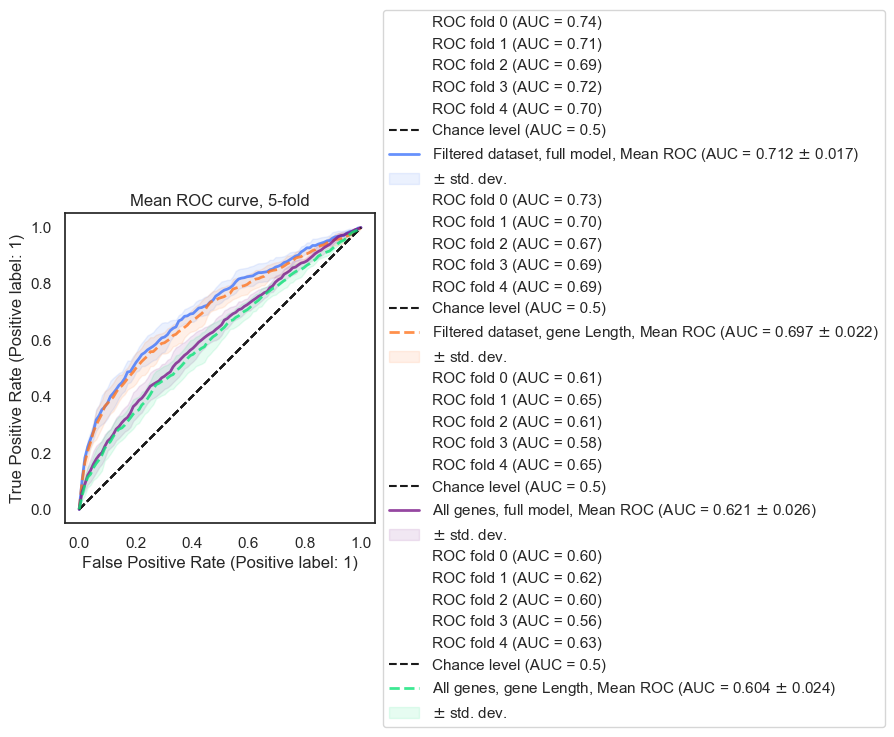

In [89]:
# keep only top feature
coefs = coefs_kfold(DF_filtered, f_short_num, f_cat, 'Label' , 5, classifier)
coefs['abs mean'] = np.abs(coefs['mean'])
coefs.sort_values('abs mean', inplace= True, ascending=False)

n_feat = 12
tmp = set(coefs.head(n_feat).index)
n = list(set(f_short_num) & tmp)
c = list(set(f_cat) & tmp)

classifier = LogisticRegression(max_iter=500, penalty='l2', solver='newton-cholesky', class_weight='balanced')
sns.set_style("white")
fig, ax = plt.subplots(figsize=(4, 8))
ax.set(
        xlim=[-0.05, 1.05],
        ylim=[-0.05, 1.05],
        xlabel="False Positive Rate",
        ylabel="True Positive Rate",
        title=f"Mean ROC curve, 5-fold",
    )
ax.axis("square")

m1, s1 = CV_roc_curve(DF_filtered, n, c, 'Label', fig, ax, 5, classifier, '#4176FC', 'Filtered dataset, full model')
m2, s2 = CV_roc_curve(DF_filtered, ['geneLen'], [], 'Label', fig, ax, 5, classifier, '#FF751F', 'Filtered dataset, gene Length', linestyle='dashed')

m1, s1 = CV_roc_curve(DF_imputed, n, c, 'Numeric Label', fig, ax, 5, classifier, '#7B198A', 'All genes, full model')
m2, s2 = CV_roc_curve(DF_imputed, ['geneLen'], [], 'Numeric Label', fig, ax, 5, classifier, '#0CE378', 'All genes, gene Length', linestyle='dashed')
plt.savefig('plots/LogisticRegression_5fold_ROCcurve_filtered.pdf')
plt.show()

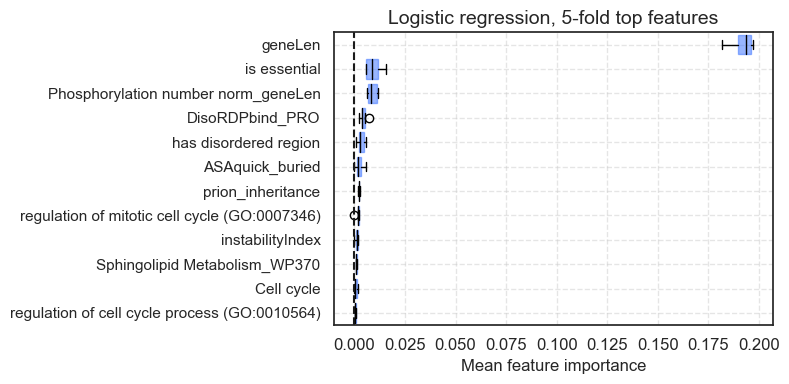

['#336DFF', '#336DFF', '#336DFF', '#336DFF', '#336DFF', '#336DFF', '#336DFF', '#336DFF', '#336DFF', '#336DFF', '#336DFF', '#336DFF']


In [103]:
FI = permutation_importance_kfold(DF_filtered, n, c, 'Label', 5, classifier, n_repeats= 10, scoring='roc_auc')
coefs = coefs_kfold(DF_filtered, n, c, 'Label' , 5, classifier)
plot_FI_coef_col(FI, coefs, figsize=(8,4), c1 = '#336DFF', c2 = '#336DFF', savefig='plots/permutation_feature_importance_Logit_top12_FINAL.svg')

In [104]:
cat_num_ranksum = pd.concat([num_ranksum, cat_ranksum])

In [106]:
FI = FI.join(cat_num_ranksum)

In [107]:
coefs = coefs.rename(columns={'mean': 'coefs'})

In [108]:
FI = FI.join(coefs[['coefs']])

In [109]:
FI['sign wilc'] = 'N'
FI.loc[FI['Statistic'] > 0, 'sign wilc'] = 'T'

FI['sign coef'] = 'N'
FI.loc[FI['coefs'] > 0, 'sign coef'] = 'T'

In [110]:
FI.sort_values('mean', ascending=False).head(12).to_excel('result_datasets/Permutation_importance_signs.xlsx')

In [111]:
num_ranksum

,p-value,Statistic,FDR bh
geneLen,1.545692e-25,10.444930,1.700261e-23
variants_effect_synonymous_variant,4.469634e-15,7.841003,1.419159e-13
variants_impact_LOW,4.515263e-15,7.839727,1.419159e-13
variants_impact_MODERATE,5.160577e-15,7.822935,1.419159e-13
variants_effect_missense_variant,1.709095e-14,7.670813,3.760009e-13
...,...,...,...
number of genetic interaction,9.686437e-01,-0.039309,9.961671e-01
number of negative genetic interaction,9.772204e-01,0.028554,9.961671e-01
variants_impact_MODIFIER,9.832223e-01,-0.021029,9.961671e-01
variants_effect_intron_variant,9.883773e-01,0.014567,9.961671e-01


In [112]:
rs = ranksums(list(DF_filtered[DF_filtered.Label == 1]['geneLen']), list(DF_filtered[DF_filtered.Label == 0]['geneLen']))

meta NOT subset; don't know how to subset; dropped


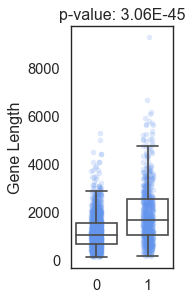

In [115]:

sns.set(font_scale=1.2)
sns.set_style("white")
plt.figure(figsize=(2.5, 4), dpi=80) 
ax = sns.stripplot(data=DF_filtered, x="Label", y='geneLen', zorder=0, alpha=0.2, color='cornflowerblue')
fdr = '%.2E' % Decimal(rs[1])
ax.set(title='p-value: ' + fdr)
# plot boxplot
sns.boxplot(data=DF_filtered, x="Label", y='geneLen', 
                 boxprops={'facecolor':'None'},
                 showfliers=False, ax=ax)
ax.set(xlabel=None)

plt.ylabel('Gene Length')

plt.tight_layout()
plt.savefig('plots/geneLength_df_filtered.pdf')

In [116]:
new_rc_params = {'text.usetex': False, "svg.fonttype": 'none'}
plt.rcParams.update(new_rc_params)

meta NOT subset; don't know how to subset; dropped


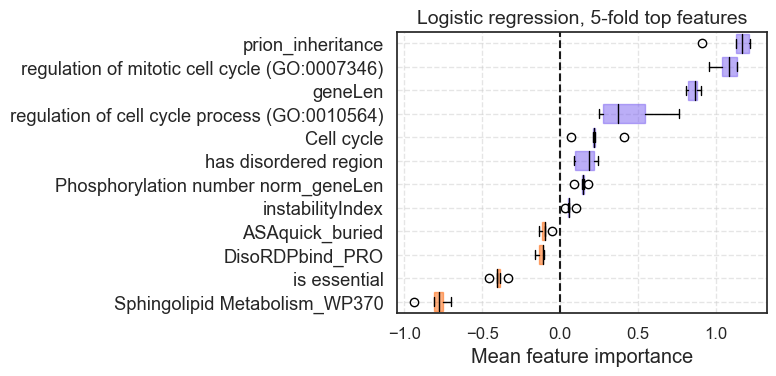

['#FE6100', '#FE6100', '#FE6100', '#FE6100', '#785EF0', '#785EF0', '#785EF0', '#785EF0', '#785EF0', '#785EF0', '#785EF0', '#785EF0']


In [118]:
coefs = coefs_kfold(DF_filtered, n, c, 'Label' , 5, classifier)
plot_FI_coef_col(coefs, coefs, c1 = '#785EF0', c2 = '#FE6100', figsize=(8,4), savefig='plots/Coefs_boxplot_Logit_top12_FINAL.pdf')

meta NOT subset; don't know how to subset; dropped


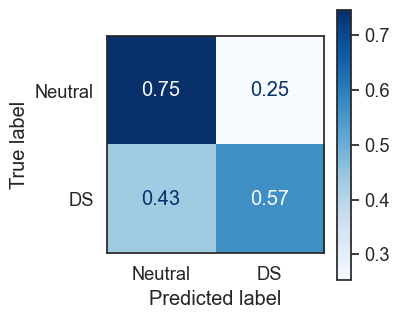

In [119]:
CV_confusion(DF_filtered, n, c, 'Label', model=classifier, n_splits=5, normalize='true', list_labels=['Neutral', 'DS'])
plt.savefig('plots/confusion_matrix_filtered_top12feats.pdf')

## Select feature using feature importance instead

plot_FI(FI)

FI = permutation_importance_kfold(DF_filtered, n, c, 'Label', 5, classifier, n_repeats= 10, scoring='roc_auc')
plot_FI(FI)

CV_confusion(DF_filtered, n, c, 'Label', model=classifier, n_splits=5, normalize='true', list_labels=['Neutral', 'DS'])

# Without gene length & variants

In [120]:
features = ['Ribo_profilling_init_rate',
 'Ribo_profilling_trans_rate',
 'ASAquick_buried',
 'alpha IDRratio',
 'DisoRDPbind_PRO',
 'IDR ratio mean',
 'IDR ratio',
 'MMseq2_low_conservation',
 'MMseq2_high_conservation',
 '%AA_S',
 "5'-UTR_length",
 'Phosphorylation number norm_geneLen',
 'instabilityIndex']

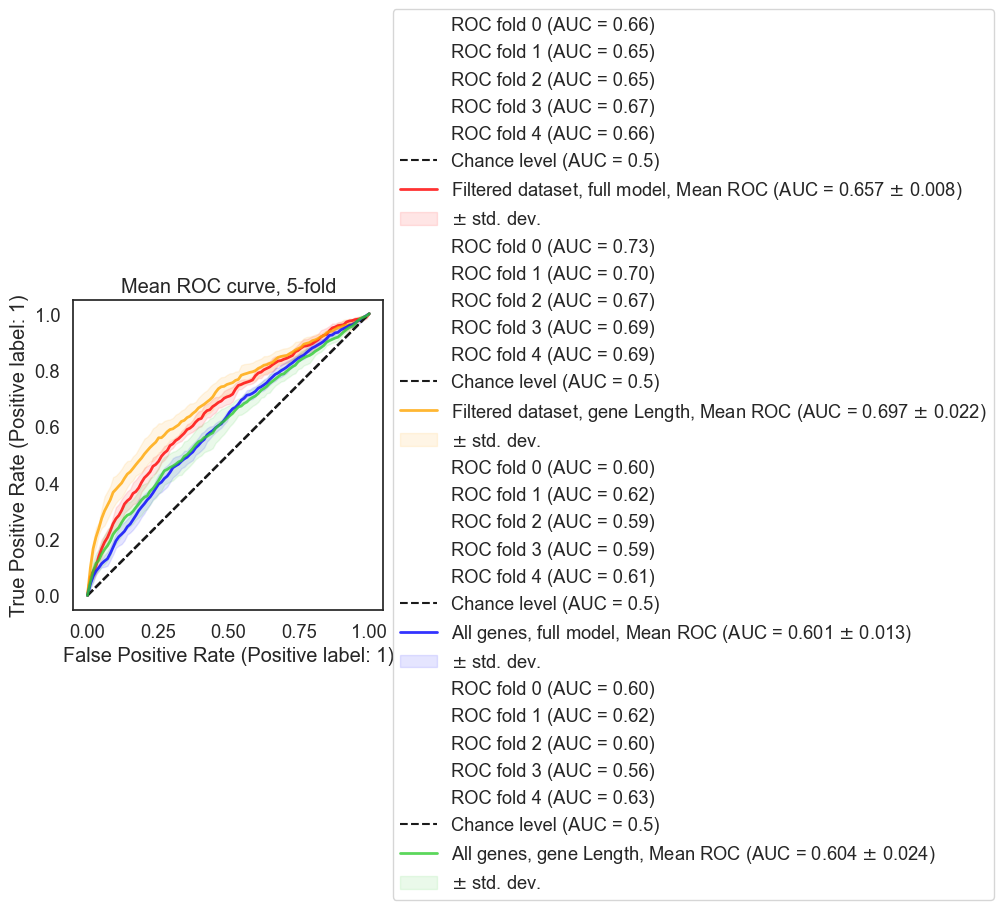

In [121]:
classifier = LogisticRegression(max_iter=500, penalty='l2', solver='newton-cholesky', class_weight='balanced')
sns.set_style("white")
fig, ax = plt.subplots(figsize=(4, 8))
ax.set(
        xlim=[-0.05, 1.05],
        ylim=[-0.05, 1.05],
        xlabel="False Positive Rate",
        ylabel="True Positive Rate",
        title=f"Mean ROC curve, 5-fold",
    )
ax.axis("square")

m1, s1 = CV_roc_curve(DF_filtered, features, f_cat, 'Label', fig, ax, 5, classifier, 'red', 'Filtered dataset, full model')
m2, s2 = CV_roc_curve(DF_filtered, ['geneLen'], [], 'Label', fig, ax, 5, classifier, 'orange', 'Filtered dataset, gene Length')

m1, s1 = CV_roc_curve(DF_imputed, features, f_cat, 'Numeric Label', fig, ax, 5, classifier, 'blue', 'All genes, full model')
m2, s2 = CV_roc_curve(DF_imputed, ['geneLen'], [], 'Numeric Label', fig, ax, 5, classifier, 'limegreen', 'All genes, gene Length')
#plt.savefig('plots/LogisticRegression_5fold_ROCcurve_filtered.pdf')
plt.show()

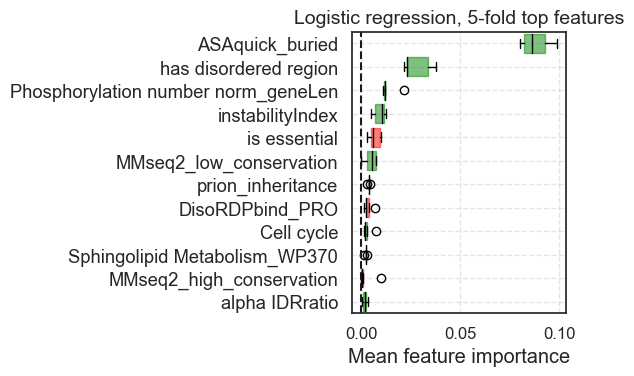

['green', 'red', 'red', 'green', 'red', 'green', 'green', 'red', 'green', 'green', 'green', 'green']


In [122]:
coefs = coefs_kfold(DF_filtered, features, f_cat, 'Label' , 5, classifier)
FI = permutation_importance_kfold(DF_filtered, features, f_cat, 'Label' , 5, classifier, scoring='roc_auc')
plot_FI_coef_col(FI, coefs, figsize=(6,4))

# Is there interaction between terms
https://christophm.github.io/interpretable-ml-book/interaction.html#theory-friedmans-h-statistic

In [123]:
f = f_short_num + f_cat
f.append('Label')
interaction_DF = DF_filtered[f]

In [124]:
for x in range(1, len(f)-1):
    interaction_DF['geneLen * ' + f[x]] = interaction_DF['geneLen'] * interaction_DF[f[x]]

C:\Users\user\AppData\Local\Temp\ipykernel_13060\2209358120.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  interaction_DF['geneLen * ' + f[x]] = interaction_DF['geneLen'] * interaction_DF[f[x]]
C:\Users\user\AppData\Local\Temp\ipykernel_13060\2209358120.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  interaction_DF['geneLen * ' + f[x]] = interaction_DF['geneLen'] * interaction_DF[f[x]]
C:\Users\user\AppData\Local\Temp\ipykernel_13060\2209358120.py:2: SettingWithCopyWarning: 
A value is trying to be

In [125]:
num = list(set(interaction_DF.columns) - set(f_cat))
num.remove('Label')

C:\Users\user\anaconda3\lib\site-packages\seaborn\matrix.py:1124: UserWarning: ``square=True`` ignored in clustermap
  warnings.warn(msg)


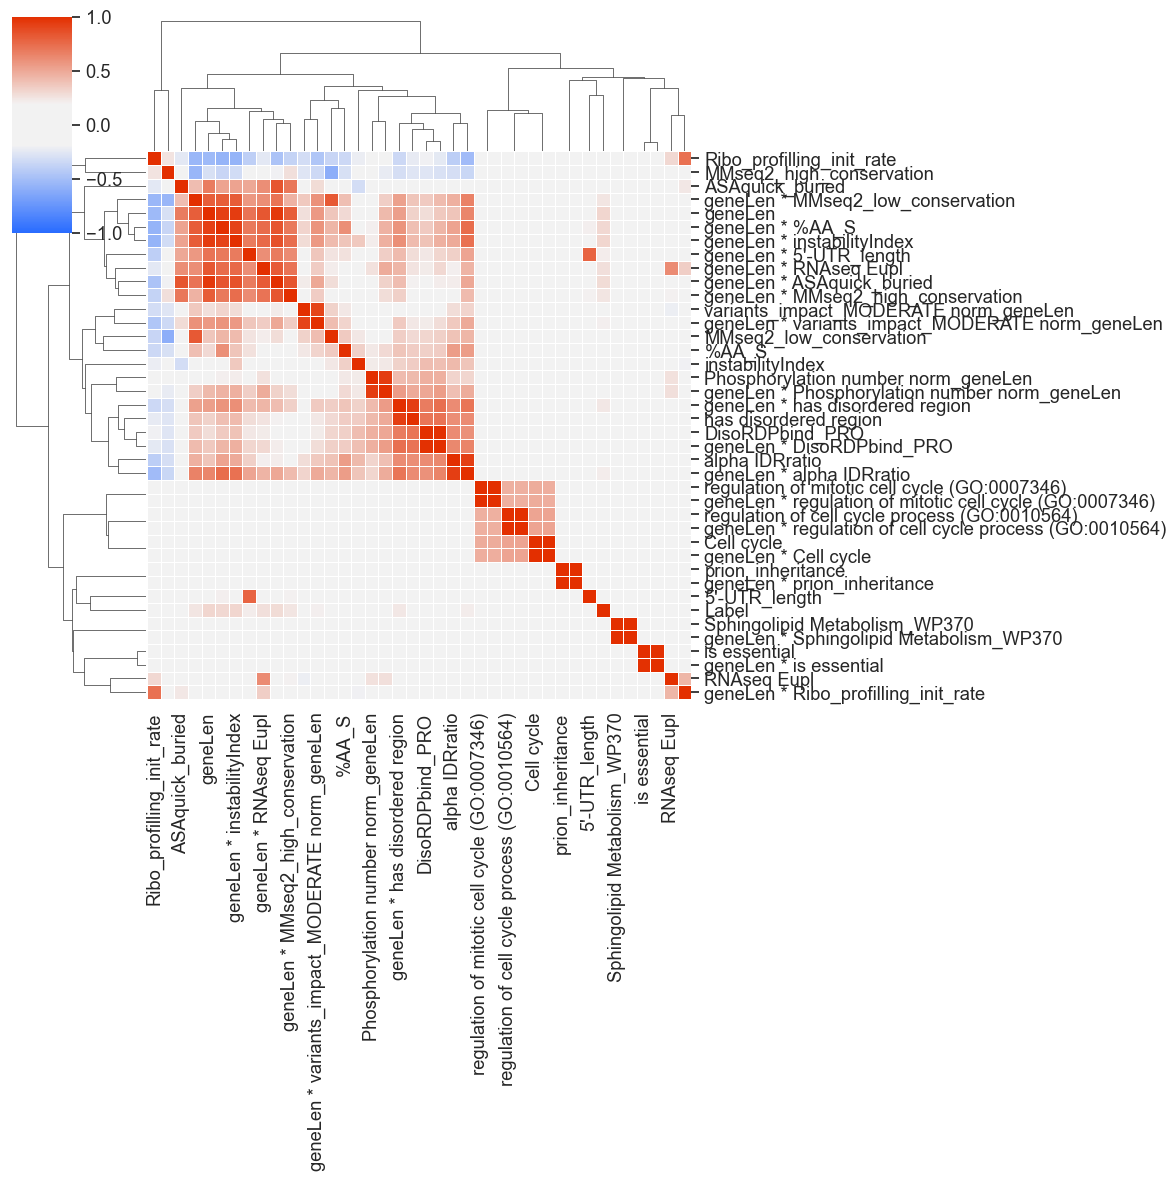

In [126]:
cmap = sns.diverging_palette(260, 15, s=100, as_cmap=True, sep=50)
corr = interaction_DF.corr(method='spearman')
sns.clustermap(corr, colors_ratio=1, cmap=cmap, yticklabels=True, figsize=(12,12),
               robust=False, vmin=-1, vmax=1, square = True, dendrogram_ratio=0.2, linewidths=.5)
#plt.savefig('plots/heatmap_spearman_correlation_moby1_sign_features.pdf')

In [127]:
coefs = coefs_kfold(interaction_DF, num , f_cat, 'Label' , 5, classifier)
coefs['abs mean'] = np.abs(coefs['mean'])
coefs.sort_values('abs mean', inplace= True, ascending=False)
for n_feat in range(2, len(num+f_cat)):
    tmp = set(coefs.head(n_feat).index)
    n = list(set(num) & tmp)
    c = list(set(f_cat) & tmp)

    score_T, score_V = train_model(interaction_DF, n, c, 'Label', classifier)
    print(n_feat, ':')
    print('Test ROC, mean: ', score_V)

2 :
Test ROC, mean:  0.6939834497040186
3 :
Test ROC, mean:  0.6965105114416819
4 :
Test ROC, mean:  0.6960234046970781
5 :
Test ROC, mean:  0.6953927725961769
6 :
Test ROC, mean:  0.6968308368262672
7 :
Test ROC, mean:  0.701377226887023
8 :
Test ROC, mean:  0.7058783742738731
9 :
Test ROC, mean:  0.70808347862669
10 :
Test ROC, mean:  0.7084092440121458
11 :
Test ROC, mean:  0.7103413509879496
12 :
Test ROC, mean:  0.7116357991950613
13 :
Test ROC, mean:  0.7126761993615254
14 :
Test ROC, mean:  0.7154779811431438
15 :
Test ROC, mean:  0.7180580828892933
16 :
Test ROC, mean:  0.7183642189382751
17 :
Test ROC, mean:  0.7190354697123418
18 :
Test ROC, mean:  0.7157121731806143
19 :
Test ROC, mean:  0.7156734131744128
20 :
Test ROC, mean:  0.7153826451278898
21 :
Test ROC, mean:  0.7143183542909367
22 :
Test ROC, mean:  0.7141907409371852
23 :
Test ROC, mean:  0.7101566629583995
24 :
Test ROC, mean:  0.7108700737392118
25 :
Test ROC, mean:  0.7104731803423755
26 :
Test ROC, mean:  0.710

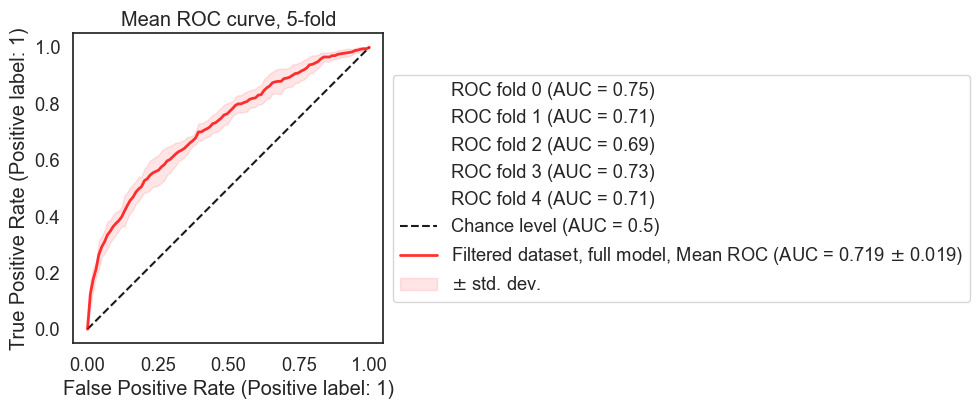

In [128]:
# keep only top feature
coefs = coefs_kfold(interaction_DF, num , f_cat, 'Label' , 5, classifier)
coefs['abs mean'] = np.abs(coefs['mean'])
coefs.sort_values('abs mean', inplace= True, ascending=False)

n_feat = 17
tmp = set(coefs.head(n_feat).index)
n = list(set(num) & tmp)
c = list(set(f_cat) & tmp)

classifier = LogisticRegression(max_iter=500, penalty='l2', solver='newton-cholesky', class_weight='balanced')
sns.set_style("white")
fig, ax = plt.subplots(figsize=(4, 8))
ax.set(
        xlim=[-0.05, 1.05],
        ylim=[-0.05, 1.05],
        xlabel="False Positive Rate",
        ylabel="True Positive Rate",
        title=f"Mean ROC curve, 5-fold",
    )
ax.axis("square")

m1, s1 = CV_roc_curve(interaction_DF, n, c, 'Label', fig, ax, 5, classifier, 'red', 'Filtered dataset, full model')
#plt.savefig('plots/LogisticRegression_5fold_ROCcurve_filtered.pdf')
plt.show()

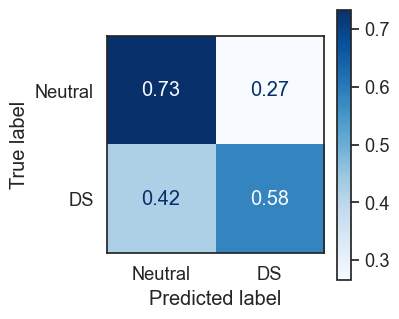

In [129]:
CV_confusion(interaction_DF, n, c, 'Label', classifier, n_splits=5, normalize='true', list_labels=['Neutral', 'DS'])

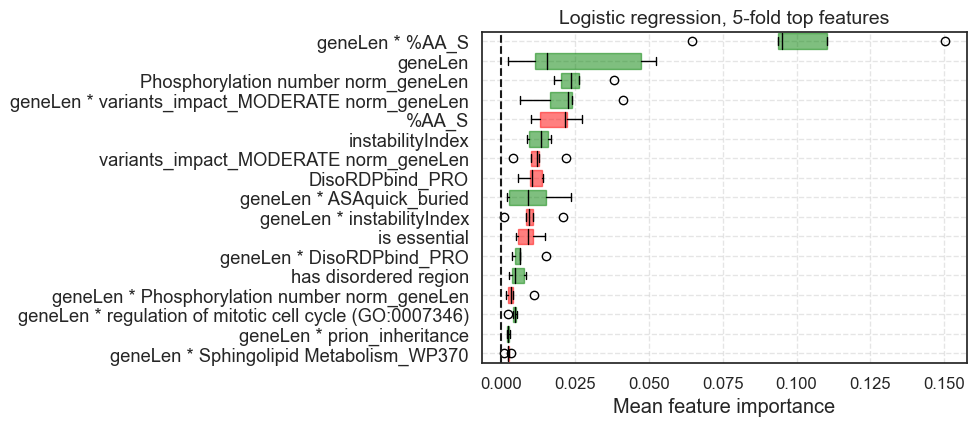

['red', 'green', 'green', 'red', 'green', 'green', 'red', 'red', 'green', 'red', 'red', 'green', 'red', 'green', 'green', 'green', 'green']


In [130]:
FI = permutation_importance_kfold(interaction_DF, n, c, 'Label', 5, classifier, n_repeats= 10, scoring='roc_auc')
coefs = coefs_kfold(interaction_DF, n , c, 'Label' , 5, classifier)
plot_FI_coef_col(FI, coefs, 17)